# Thermo-mechanical NTFA - results of the CMAME article

Felix Fritzen <fritzen@simtech.uni-stuttgart.de>,
Julius Herb <julius.herb@mib.uni-stuttgart.de>,
Shadi Sharba <shadi.sharba@isc.fraunhofer.de>

University of Stuttgart, Institute of Applied Mechanics, Chair for Data Analytics in Engineering

> **Funding acknowledgment**
> The IGF-Project no.: 21.079 N / DVS-No.: 06.3341 of the
> “Forschungsvereinigung Schweißen und verwandte Verfahren e.V.” of the
> German Welding Society (DVS), Aachener Str. 172, 40223 Düsseldorf, Germany,
> was funded by the Federal Ministry for Economic Affairs and Climate Action (BMWK)
> via the German Federation of Industrial Research Associations (AiF) in accordance
> with the policy to support the Industrial Collective Research (IGF)
> on the orders of the German Bundestag.
>
> Felix Fritzen is funded by the German Research Foundation (DFG) --
> 390740016 (EXC-2075); 406068690 (FR2702/8-1); 517847245 (FR2702/10-1).

## Imports:

In [1]:
import os

import h5py
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource

from material_parameters import *
from thermontfa import TabularInterpolation, ThermoMechNTFA


plt.rcParams["figure.dpi"] = 400
# matplotlib.rc("font", size=8)
colors = [
    "#004191",
    "#00BEFF",
    "tab:orange",
    "tab:red",
    "tab:olive",
    "tab:green",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:cyan",
    "tab:purple",
    "tab:blue",
]
markers = ["o", "d", "s", "+", "^", "x", "p", "*", "v", "1", "P", "."]
plot_width = 2 * 4.68596
matplotlib.rcParams["axes.prop_cycle"] = matplotlib.cycler(color=colors)

data_path = "../data"


def Vec2Tensor(vec):
    """Convert a 6-vector (in Mandel notation) into a sym. 3x3 Matrix"""
    A = np.zeros((3, 3))
    A[0, 0] = vec[0]
    A[1, 1] = vec[1]
    A[2, 2] = vec[2]
    A[0, 1] = np.sqrt(0.5) * vec[3]
    A[1, 0] = A[0, 1]
    A[0, 2] = np.sqrt(0.5) * vec[4]
    A[2, 0] = A[0, 2]
    A[1, 2] = np.sqrt(0.5) * vec[5]
    A[2, 1] = A[1, 2]
    return A


def rel_error(A, A_ref, r_min=None):
    if r_min is None:
        return np.linalg.norm(A - A_ref, axis=1) / np.linalg.norm(A_ref, axis=1)
    else:
        return np.linalg.norm(A - A_ref, axis=1) / (
            np.maximum(r_min, np.linalg.norm(A_ref, axis=1))
        )

**Load the NTFA data**
- Read the tabularized data for all operators individually
- This also happens inside of the ThermoNTFA class during initialization

In [2]:
mode_fn = os.path.join(
    data_path, "ntfa_raw", "rve_thermoplastic_6loadings_10samples.h5"
)
A_bar = TabularInterpolation.from_h5(
    mode_fn,
    "/ms_9p/dset0_ntfa/temperatures",
    "/ms_9p/dset0_ntfa/A_bar",
    transpose_dims=(2, 0, 1),
)
C_bar = TabularInterpolation.from_h5(
    mode_fn,
    "/ms_9p/dset0_ntfa/temperatures",
    "/ms_9p/dset0_ntfa/C_bar",
    transpose_dims=(2, 0, 1),
)
A_cu = TabularInterpolation.from_h5(
    mode_fn,
    "/ms_9p/dset0_ntfa/temperatures",
    "/ms_9p/dset0_ntfa/A0",
    transpose_dims=(2, 0, 1),
)
A_ftc = TabularInterpolation.from_h5(
    mode_fn,
    "/ms_9p/dset0_ntfa/temperatures",
    "/ms_9p/dset0_ntfa/A1",
    transpose_dims=(2, 0, 1),
)
C_cu = TabularInterpolation.from_h5(
    mode_fn,
    "/ms_9p/dset0_ntfa/temperatures",
    "/ms_9p/dset0_ntfa/C0",
    transpose_dims=(2, 0, 1),
)
C_ftc = TabularInterpolation.from_h5(
    mode_fn,
    "/ms_9p/dset0_ntfa/temperatures",
    "/ms_9p/dset0_ntfa/C1",
    transpose_dims=(2, 0, 1),
)

# number of modes - needed to truncate A!
N_modes = 24
A_bar.data = A_bar.data[:, :, :N_modes]
A_cu.data = A_cu.data[:, :, : (7 + N_modes)]
A_ftc.data = A_ftc.data[:, :, : (7 + N_modes)]

for A in [A_bar, A_cu, A_ftc]:
    A.dim = A.data.shape

## Mode study

## Training reproduction tests

## Analysis of the training directions of the temperature range

### Load data from hdf5 files
- compare efficiency of the interpolation over the temperature
- show select stress-strain curves
- results are generated based on `generate_inputs.py` and external C/C++ UMAT

### Analysis of the training directions of the temperature range

First figure: comparison of $\theta$-NTFA and FEM for training scenarios

loadcases: 0, 2, 5

temperatures: 0, 3, 9  (0, 33, -1)

N_modes: 12, 18, 24

In [3]:
data_sig_ntfa = np.zeros((3, 3, 3, 11, 6))
data_sig_fans = np.zeros((3, 3, 3, 11, 6))

line_style = [
    {"linewidth": 2, "color": colors[0], "linestyle": "solid", "markersize": 6},
    {"linewidth": 2, "color": colors[1], "linestyle": "dashed", "markersize": 6},
    {"linewidth": 2, "color": colors[3], "linestyle": "dotted", "markersize": 6},
]

for i, N_modes in enumerate((12, 18, 24)):
    fname = f"all_results_ms9p_16x16x16_100s_N{N_modes}.h5"
    fname = os.path.join(
        data_path, "results", f"reproduction_6loadings_100samples_N{N_modes}.h5"
    )
    with h5py.File(fname, "r") as F:
        eps = np.array(F["/eps"])
        theta = np.array(F["/temperature"])
        fans_sig = np.array(F["/fans/sig"])
        fans_sig_cu = np.array(F["/fans/sig0"])
        fans_sig_ftc = np.array(F["/fans/sig1"])
        ntfa_sig = np.array(F["/ntfa/sig"])
        ntfa_sig_cu = np.array(F["/ntfa/sig0"])
        ntfa_sig_ftc = np.array(F["/ntfa/sig1"])
        ntfa_q = np.array(F["/ntfa/q"])
        ntfa_xi = np.array(F["/ntfa/xi"])

    print(i)
    print(eps[0, 1, -1, :])
    data_sig_ntfa[0, 0, i, :, :] = ntfa_sig[0, 2, :, :]
    data_sig_ntfa[1, 0, i, :, :] = ntfa_sig[0, 1, :, :]
    data_sig_ntfa[2, 0, i, :, :] = ntfa_sig[0, 5, :, :]

    data_sig_ntfa[0, 1, i, :, :] = ntfa_sig[33, 2, :, :]
    data_sig_ntfa[1, 1, i, :, :] = ntfa_sig[33, 1, :, :]
    data_sig_ntfa[2, 1, i, :, :] = ntfa_sig[33, 5, :, :]

    data_sig_ntfa[0, 2, i, :, :] = ntfa_sig[-1, 2, :, :]
    data_sig_ntfa[1, 2, i, :, :] = ntfa_sig[-1, 1, :, :]
    data_sig_ntfa[2, 2, i, :, :] = ntfa_sig[-1, 5, :, :]

    data_sig_fans[0, 0, i, :, :] = fans_sig[0, 2, :, :]
    data_sig_fans[1, 0, i, :, :] = fans_sig[0, 1, :, :]
    data_sig_fans[2, 0, i, :, :] = fans_sig[0, 5, :, :]

    data_sig_fans[0, 1, i, :, :] = fans_sig[33, 2, :, :]
    data_sig_fans[1, 1, i, :, :] = fans_sig[33, 1, :, :]
    data_sig_fans[2, 1, i, :, :] = fans_sig[33, 5, :, :]

    data_sig_fans[0, 2, i, :, :] = fans_sig[-1, 2, :, :]
    data_sig_fans[1, 2, i, :, :] = fans_sig[-1, 1, :, :]
    data_sig_fans[2, 2, i, :, :] = fans_sig[-1, 5, :, :]

0
[ 0.          0.01414214 -0.01414214  0.          0.          0.        ]
1
[ 0.          0.01414214 -0.01414214  0.          0.          0.        ]
2
[ 0.          0.01414214 -0.01414214  0.          0.          0.        ]


### Relative error in sig_bar for 300K, 633.3K and 1300 K

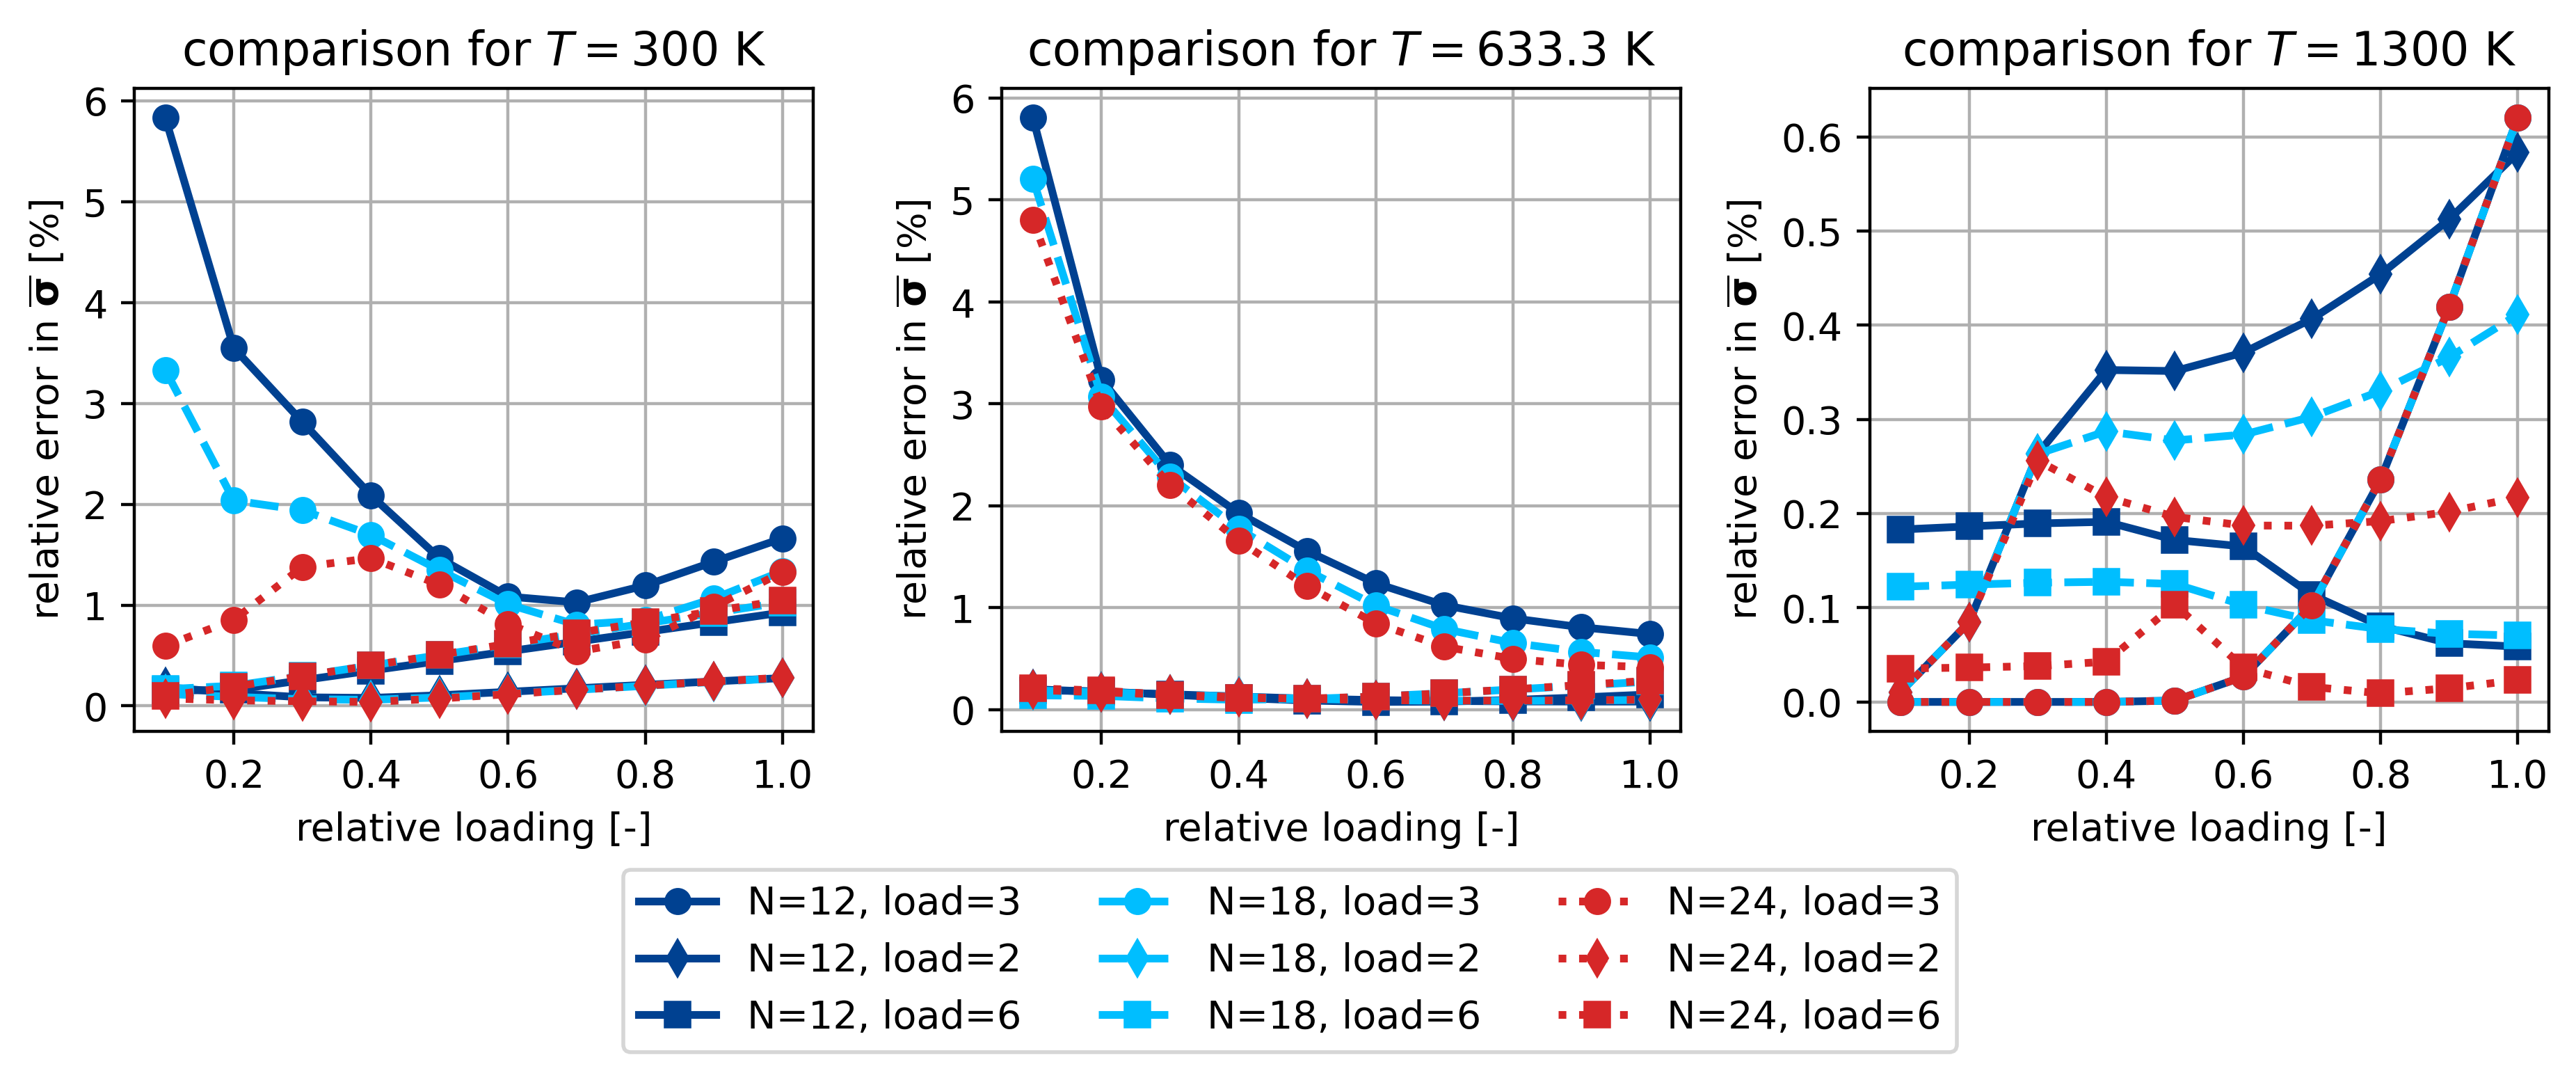

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(plot_width, 3.25))
Temp = [theta[0], theta[33], theta[-1]]
load = np.linspace(0, 1, 11)
m = ["o", "d", "s"]
P2 = np.eye(6)
J_load = (3, 2, 6)
for i_mode in range(3):
    N_modes = (12, 18, 24)[i_mode]
    for i_load in range(3):
        for i_temp in range(3):
            T = Temp[i_temp]
            s = data_sig_fans[i_temp, i_load, i_mode, :, :] @ P2
            ds = data_sig_ntfa[i_temp, i_load, i_mode, :, :] @ P2 - s
            err = np.linalg.norm(ds, axis=1) / np.linalg.norm(s, axis=1) * 100.0
            if i_temp == 0:
                ax[i_temp].plot(
                    load[1:],
                    err[1:],
                    label=f"N={N_modes}, load={J_load[i_load]}",
                    **line_style[i_mode],
                    marker=m[i_load],
                )
            else:
                ax[i_temp].plot(
                    load[1:], err[1:], **line_style[i_mode], marker=m[i_load]
                )
for a in ax:
    # a.legend()
    a.grid()
    a.set_xlabel("relative loading [-]")
    a.set_ylabel(r"relative error in $\overline{\mathbf{\sigma}}$ [%]")

fig.legend(ncol=3, loc="lower center", bbox_to_anchor=(0, -0.2, 1, 1))

ax[0].set_title(r"comparison for $T=$300 K")
ax[1].set_title(r"comparison for $T=$633.3 K")
ax[2].set_title(r"comparison for $T=$1300 K")
fig.tight_layout()
fig.savefig(
    os.path.join(data_path, "figures", "training_reproduction.pdf"), bbox_inches="tight"
)

## Training reproduction tests

Analysis of the training directions of the temperature range

Load data from hdf5 file
- compare efficiency of the interpolation over the temperature
- show select stress-strain curves
- results are generated based on `generate_inputs.py` and external C/C++ UMAT

In [5]:
fname = os.path.join(
    data_path, "results", f"reproduction_6loadings_100samples_N{N_modes}.h5"
)
with h5py.File(fname, "r") as F:
    eps = np.array(F["/eps"])
    theta = np.array(F["/temperature"])
    fans_sig = np.array(F["/fans/sig"])
    fans_sig_cu = np.array(F["/fans/sig0"])
    fans_sig_ftc = np.array(F["/fans/sig1"])
    ntfa_sig = np.array(F["/ntfa/sig"])
    ntfa_sig_cu = np.array(F["/ntfa/sig0"])
    ntfa_sig_ftc = np.array(F["/ntfa/sig1"])
    ntfa_q = np.array(F["/ntfa/q"])
    ntfa_xi = np.array(F["/ntfa/xi"])

### Relative error in sig_bar for 300 and 1300 K

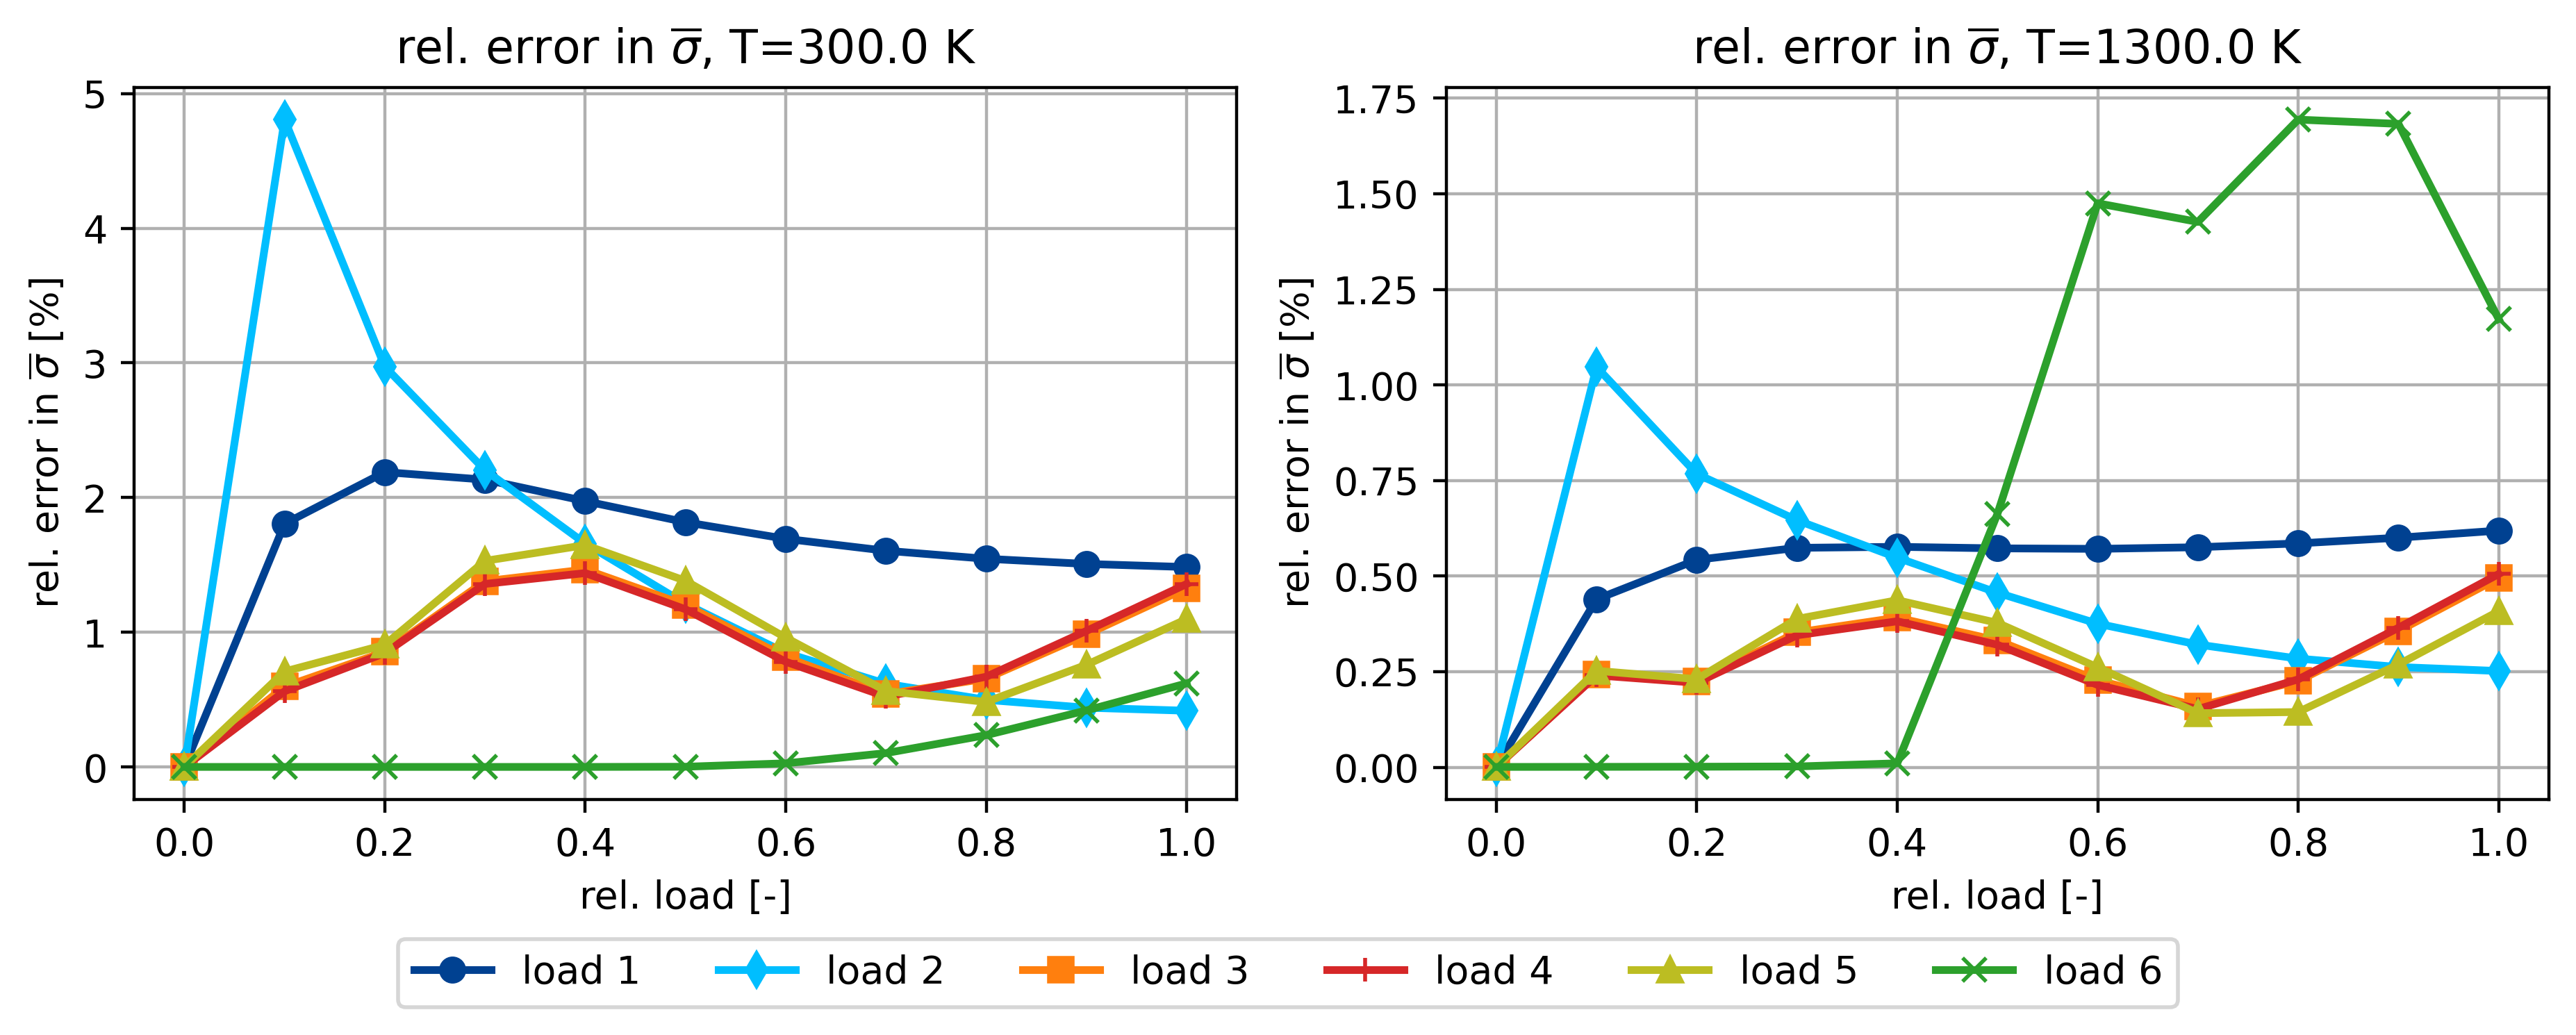

In [6]:
fig, axx = plt.subplots(1, 2, figsize=(plot_width, 3.5))
ct = 0
first_plot = True
for i_T, T in zip((0, 9), (300.0, 1300.0)):
    ax = axx[ct]
    ct += 1
    ax.set_title(r"rel. error in $\overline{\sigma}$, T=%.1f K" % T)
    x = np.linspace(0, 1, 11)
    ax.set_xlabel("rel. load [-]")
    ax.set_ylabel(r"rel. error in $\overline{\sigma}$ [%]")
    for iload in range(6):
        myerr = (
            np.linalg.norm(
                fans_sig[i_T][iload][:, :] - ntfa_sig[i_T][iload][:, :], axis=1
            )
            * 100.0
            / np.linalg.norm(fans_sig[i_T][iload][:, :], axis=1)
        )
        if first_plot:
            ax.plot(
                x,
                myerr,
                lw=2,
                label=f"load {iload+1}",
                color=colors[iload],
                marker=markers[iload],
            )
        else:
            ax.plot(x, myerr, lw=2, color=colors[iload], marker=markers[iload])
    # ax.legend()
    ax.grid()
    first_plot = False

fig.legend(ncol=6, loc="lower center", bbox_to_anchor=(0, -0.07, 1, 1))

fig.tight_layout()
fig.savefig(
    os.path.join(data_path, "figures", "rel_err_sig_10s.pdf"),
    format="pdf",
    bbox_inches="tight",
)

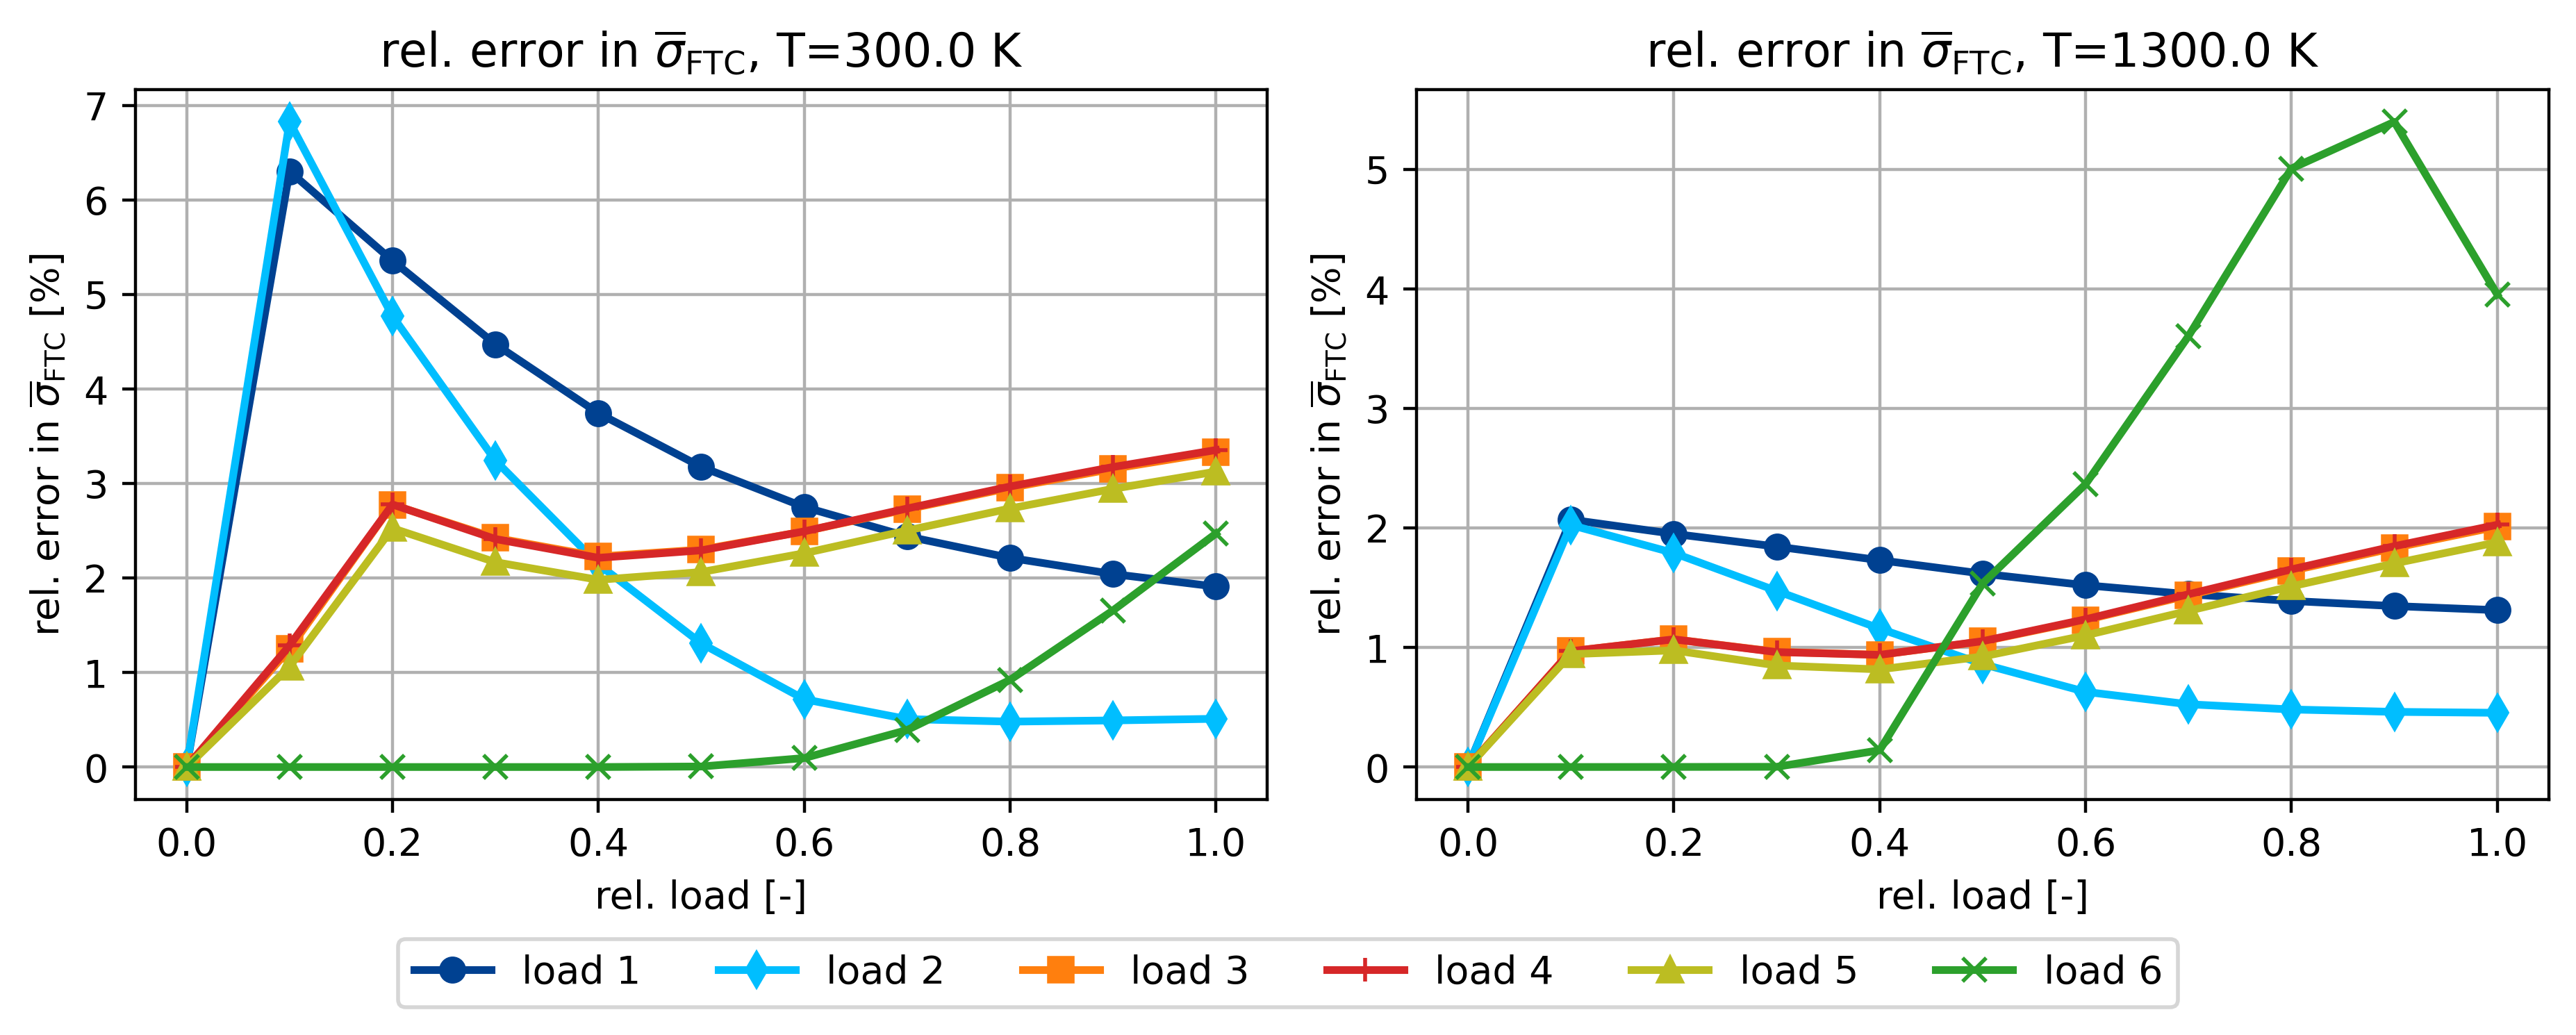

In [7]:
fig, axx = plt.subplots(1, 2, figsize=(plot_width, 3.5))
ct = 0
first_plot = True
for i_T, T in zip((0, 9), (300.0, 1300.0)):
    ax = axx[ct]
    ct += 1
    ax.set_title(r"rel. error in $\overline{\sigma}_{\rm FTC}$, T=%.1f K" % T)
    x = np.linspace(0, 1, 11)
    ax.set_xlabel("rel. load [-]")
    ax.set_ylabel(r"rel. error in $\overline{\sigma}_{\sf FTC}$ [%]")
    for iload in range(6):
        myerr = (
            np.linalg.norm(
                fans_sig_ftc[i_T][iload][:, :] - ntfa_sig_ftc[i_T][iload][:, :], axis=1
            )
            * 100.0
            / np.linalg.norm(fans_sig_ftc[i_T][iload][:, :], axis=1)
        )
        if first_plot:
            ax.plot(
                x,
                myerr,
                lw=2,
                label=f"load {iload+1}",
                color=colors[iload],
                marker=markers[iload],
            )
        else:
            ax.plot(x, myerr, lw=2, color=colors[iload], marker=markers[iload])
    # ax.legend()
    ax.grid()
    first_plot = False

fig.legend(ncol=6, loc="lower center", bbox_to_anchor=(0, -0.07, 1, 1))
fig.tight_layout()
fig.savefig(
    os.path.join(data_path, "figures", "rel_err_sig_ftc_10s.pdf"),
    format="pdf",
    bbox_inches="tight",
)

### Plot the for loadcase no. 2 relevant curves

In [8]:
err = np.zeros((theta.size, fans_sig.shape[2]))
err0 = np.zeros_like(err)
err1 = np.zeros_like(err)
err_h = np.zeros_like(err)
err_eq = np.zeros_like(err)
zeta = np.zeros((eps.shape[2], ntfa_xi.shape[-1] + 7))
iload = 2
for i_T, T in enumerate(theta):
    Sref = fans_sig[i_T, iload]
    Sref0 = fans_sig_cu[i_T, iload]
    Sref1 = fans_sig_ftc[i_T, iload]
    # recompute stress of NTFA:
    zeta[:, :6] = eps[i_T, iload]
    zeta[:, 6] = 1
    zeta[:, 7:] = ntfa_xi[i_T, iload]
    ntfa_S0 = zeta @ (A_cu.interpolate(T)).T
    ntfa_S1 = zeta @ (A_ftc.interpolate(T)).T
    dS = Sref - ntfa_sig[i_T, iload, :, :]
    dS0 = Sref0 - ntfa_S0
    dS1 = Sref1 - ntfa_S1
    # errors in %
    err[i_T, :] = np.linalg.norm(dS, axis=1) / np.linalg.norm(Sref, axis=1) * 100
    err0[i_T, :] = np.linalg.norm(dS0, axis=1) / np.linalg.norm(Sref0, axis=1) * 100
    err1[i_T, :] = np.linalg.norm(dS1, axis=1) / np.linalg.norm(Sref1, axis=1) * 100
    # in MPa:
    err_h[i_T, :] = dS[:, :3].sum(axis=1) / 3.0 / 1000.0
    err_eq[i_T, :] = (
        np.maximum(0, np.linalg.norm(dS, axis=1) ** 2 - 3 * err_h[i_T, :] ** 2)
        * np.sqrt(1.5)
        / 1000.0
    )

### 3D Plots

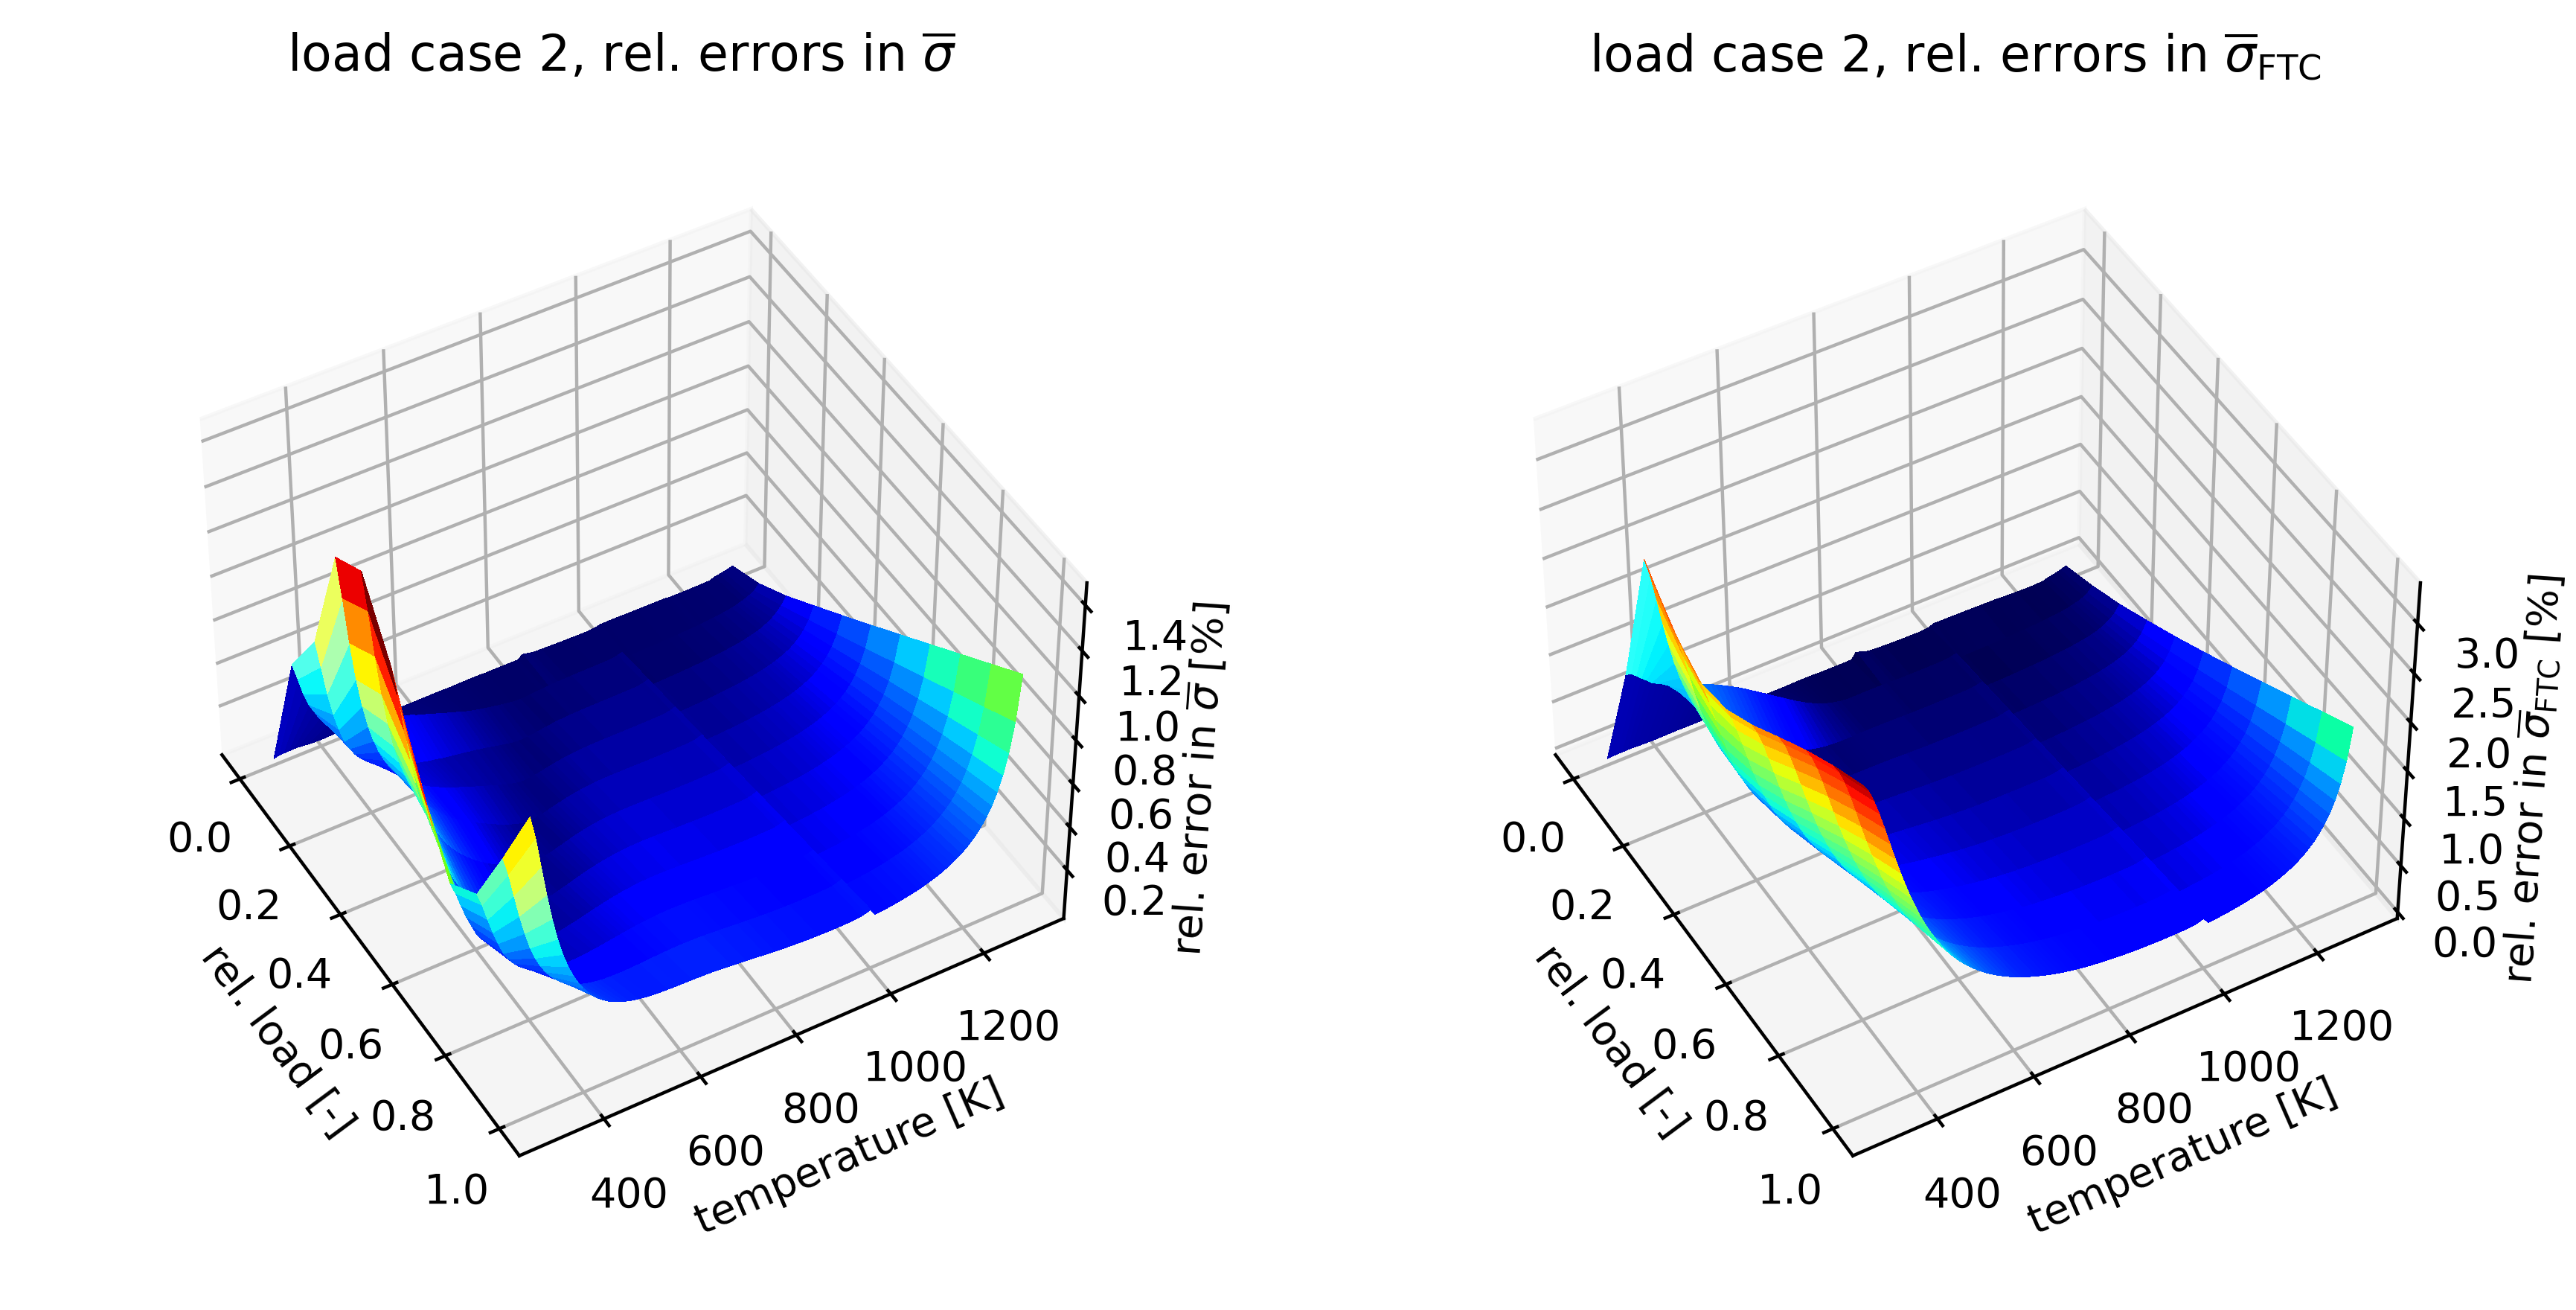

In [9]:
X = np.linspace(0, 1, fans_sig.shape[2])
Y = theta
XX, YY = np.meshgrid(X, Y)

fig, ax = plt.subplots(
    1, 2, subplot_kw=dict(projection="3d"), figsize=(plot_width, 4.5)
)
ls = LightSource(220, 45)
ZZ = err
rgb = ls.shade(ZZ, cmap=cm.jet, vert_exag=0.1, blend_mode="soft")
ax[0].view_init(elev=45, azim=-30)
surf = ax[0].plot_surface(
    XX,
    YY,
    ZZ,
    rstride=1,
    cstride=1,
    facecolors=rgb,
    linewidth=0,
    antialiased=False,
    shade=False,
)
ax[0].set_xlabel("rel. load [-]")
ax[0].set_ylabel("temperature [K]")
ax[0].set_zlabel(r"rel. error in $\overline{\sigma}$ [%]")
fig.tight_layout()
ax[0].set_title(r"load case 2, rel. errors in $\overline{\sigma}$")
ax[0].zaxis.labelpad = 0.1
ax[0].set_box_aspect(aspect=None, zoom=0.83)

ZZ = err1
rgb = ls.shade(ZZ, cmap=cm.jet, vert_exag=0.1, blend_mode="soft")
ax[1].view_init(elev=45, azim=-30)
surf = ax[1].plot_surface(
    XX,
    YY,
    ZZ,
    rstride=1,
    cstride=1,
    facecolors=rgb,
    linewidth=0,
    antialiased=False,
    shade=False,
)
ax[1].set_xlabel("rel. load [-]")
ax[1].set_ylabel("temperature [K]")
ax[1].set_zlabel(r"rel. error in $\overline{\sigma}_{\sf FTC}$ [%]")
ax[1].set_title(r"load case 2, rel. errors in $\overline{\sigma}_{\sf FTC}$")
ax[1].zaxis.labelpad = 0.1
ax[1].set_box_aspect(aspect=None, zoom=0.83)
# plt.subplots_adjust(right=0.1)
fig.tight_layout()
plt.autoscale()
fig.savefig(
    os.path.join(data_path, "figures", "surface_plots_err_sig_sig_ftc.pdf"),
    format="pdf",
)

## Random loading

# -----------------------------------------------------
# theta  355.6 K, load direction [ 0.01345955  0.00120596 -0.01442758 -0.00174739 -0.00209628 -0.00134247]
# q_initial =   0.00%
rel. error in sigma:  [0.00079347 0.01325923 0.01833459 0.02559488 0.03093237 0.03274888
 0.03258824 0.0317404  0.03077862 0.02992804 0.02925927]
rel. error in sigma_FTC:  [0.00079481 0.02919058 0.04193925 0.05161598 0.05739231 0.05805257
 0.05620802 0.05365624 0.05110733 0.048793   0.04676408]
# -----------------------------------------------------
# theta  688.9 K, load direction [ 0.01345955  0.00120596 -0.01442758 -0.00174739 -0.00209628 -0.00134247]
# q_initial =   0.00%
rel. error in sigma:  [3.08375402e-05 2.00375348e-03 2.42283629e-03 2.33070212e-03
 2.22530685e-03 2.19487064e-03 2.22543239e-03 2.29234515e-03
 2.37875831e-03 2.47497693e-03 2.57577080e-03]
rel. error in sigma_FTC:  [1.47238813e-05 4.24959542e-03 5.22217961e-03 5.16668490e-03
 5.06708409e-03 5.06360790e-03 5.12948561e-03 5.23074834

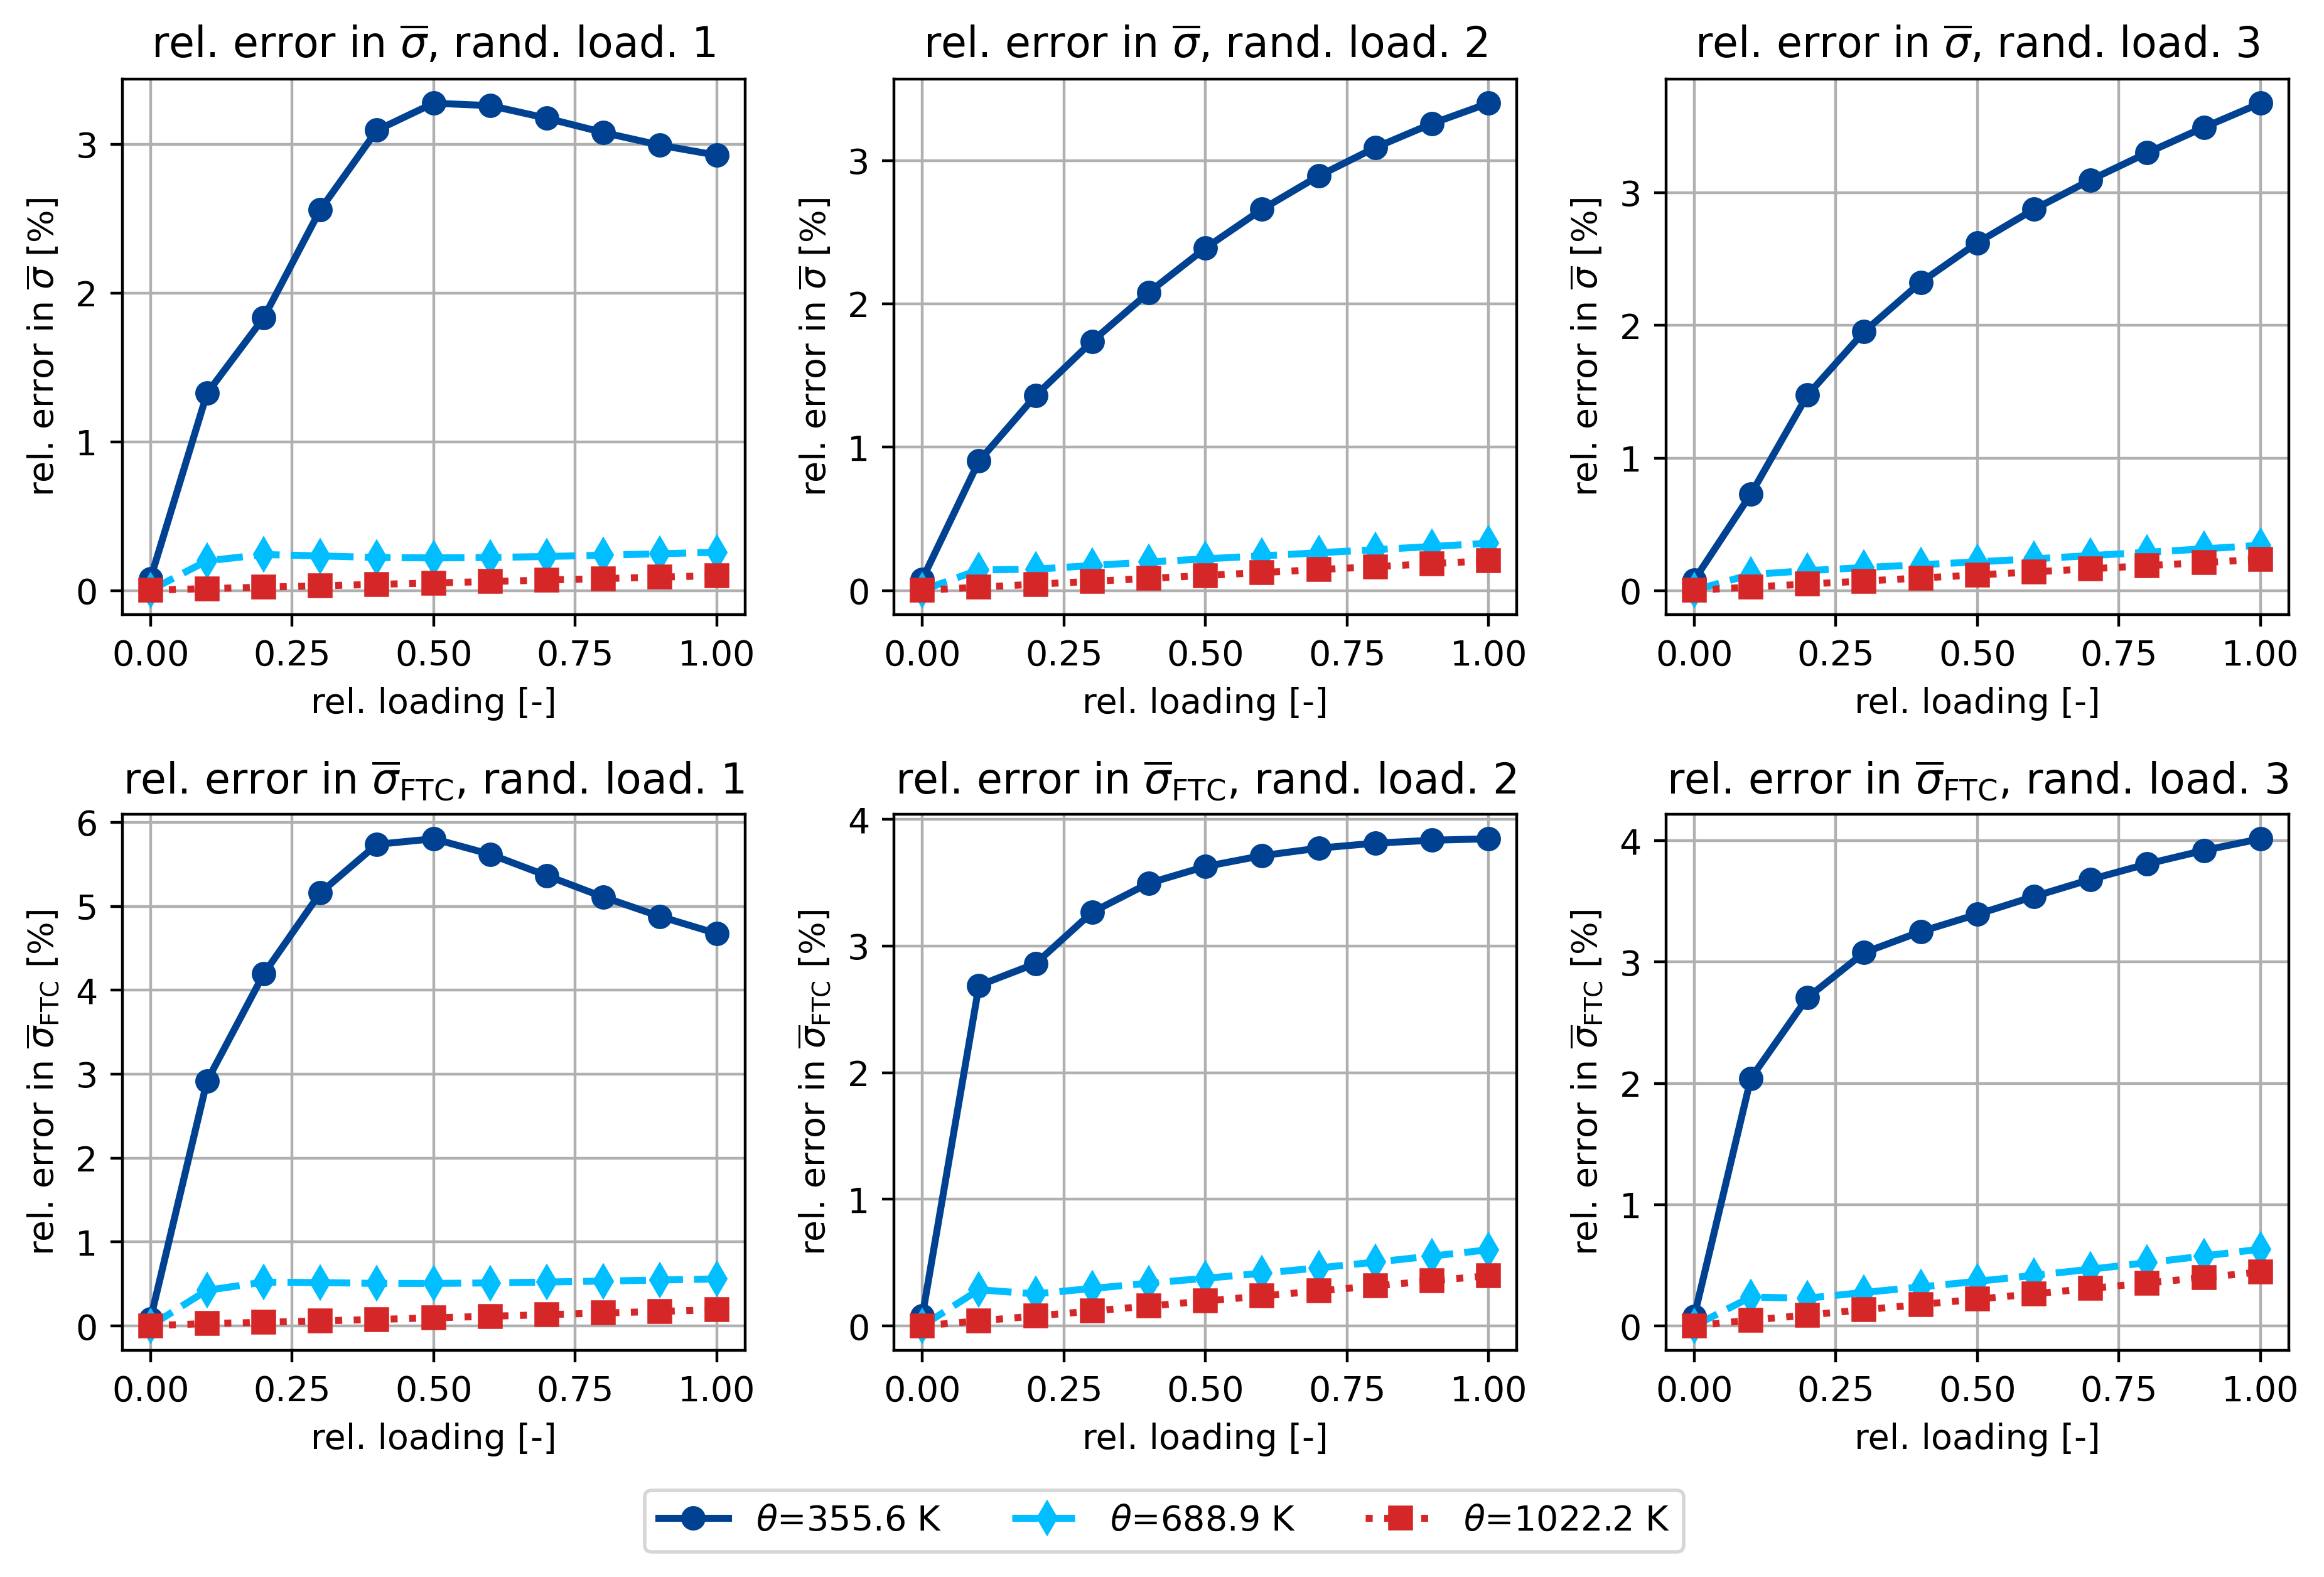

In [10]:
file_name = os.path.join(data_path, "ntfa", "ntfa_6loadings_10samples_N24.h5")
ntfa_material = ThermoMechNTFA(file_name, group_name="/", sig_y=my_sig_y, N_max=24)

loadings_file_name = os.path.join(
    data_path, "loadcases", "random_loadings_vol1e-3_dev2e-2_paper_10increments.h5"
)
with h5py.File(loadings_file_name, "r") as F:
    # load the random loadings from file and run NTFA; compare to full model
    eps_rand = np.array(F["/eps_random"][:3, :])
    fig, ax = plt.subplots(2, 3, figsize=(plot_width, 6.0))
    for i_load, E in enumerate(eps_rand):
        for i_temp, T in enumerate(("0355.6", "0688.9", "1022.2")):
            ntfa_e = np.zeros((11, 6))
            ntfa_s = np.zeros((11, 6))
            ntfa_s_ftc = np.zeros((11, 6))
            ntfa_xi = np.zeros((11, ntfa_material.n_modes))
            ntfa_q = np.zeros(11)
            theta = float(T)
            ntfa_material.interpolate(theta)
            e = np.zeros(6)
            de = np.zeros(6)
            s = np.zeros(6)
            xi = np.zeros(ntfa_material.n_modes)
            q = 0.0
            i_inc = 0
            # initial purely thermal step:
            s, q, xi, C = ntfa_material.solve(e, de, theta, q, xi)
            ntfa_s[i_inc, :] = s
            ntfa_e[i_inc, :] = e
            ntfa_q[i_inc] = q
            ntfa_s_ftc[i_inc, :] = ntfa_material.stress(e, theta, xi, i_phase=1)
            i_inc += 1
            print("# -----------------------------------------------------")
            print(f"# theta {theta:6.1f} K, load direction {E}")
            print(f"# q_initial = {100*q:6.2f}%")
            rel_load = np.linspace(0, 1, 11)
            for rl in rel_load[1:]:
                e_old = e
                e = E * rl
                de = e - e_old
                s, q, xi, C = ntfa_material.solve(e, de, theta, q, xi)
                ntfa_s[i_inc, :] = s
                ntfa_e[i_inc, :] = e
                ntfa_q[i_inc] = q
                ntfa_s_ftc[i_inc, :] = ntfa_material.stress(e, theta, xi, i_phase=1)
                i_inc += 1
            s_ref = np.array(F[f"loading{i_load}/ntfa_T{T}/fe_sig"])
            s_ftc_ref = np.array(F[f"loading{i_load}/ntfa_T{T}/fe_sig1"])
            print("rel. error in sigma: ", rel_error(ntfa_s, s_ref))
            print("rel. error in sigma_FTC: ", rel_error(ntfa_s_ftc, s_ftc_ref))
            if i_load == 0:
                ax[0, i_load].plot(
                    rel_load,
                    rel_error(ntfa_s, s_ref) * 100,
                    **line_style[i_temp],
                    marker=m[i_temp],
                    label=rf"$\theta$={theta} K",
                )
            else:
                ax[0, i_load].plot(
                    rel_load,
                    rel_error(ntfa_s, s_ref) * 100,
                    **line_style[i_temp],
                    marker=m[i_temp],
                )
            ax[0, i_load].set_ylabel(r"rel. error in $\overline{\sigma}$ [%]")
            ax[0, i_load].set_xlabel(r"rel. loading [-]")
            ax[1, i_load].set_ylabel(r"rel. error in $\overline{\sigma}_{\sf FTC}$ [%]")
            ax[1, i_load].set_xlabel(r"rel. loading [-]")
            ax[1, i_load].plot(
                rel_load,
                rel_error(ntfa_s_ftc, s_ftc_ref) * 100,
                **line_style[i_temp],
                marker=m[i_temp],
            )
    ax[0, 0].set_title(r"rel. error in $\overline{\sigma}$, rand. load. 1")
    ax[0, 1].set_title(r"rel. error in $\overline{\sigma}$, rand. load. 2")
    ax[0, 2].set_title(r"rel. error in $\overline{\sigma}$, rand. load. 3")
    ax[1, 0].set_title(r"rel. error in $\overline{\sigma}_\mathsf{FTC}$, rand. load. 1")
    ax[1, 1].set_title(r"rel. error in $\overline{\sigma}_\mathsf{FTC}$, rand. load. 2")
    ax[1, 2].set_title(r"rel. error in $\overline{\sigma}_\mathsf{FTC}$, rand. load. 3")
    for a in ax.ravel():
        a.grid()
    fig.tight_layout()
    fig.legend(ncol=3, loc="lower center", bbox_to_anchor=(0, -0.05, 1, 1))
    fig.savefig(
        os.path.join(data_path, "figures", "random_loading.pdf"), bbox_inches="tight"
    )

## Uniaxial stress-driven simulation

In [11]:
theta_list = np.linspace(300, 1300, 5)
eps_list = []
sig_list = []
sig0_list = []
sig1_list = []
q_list = []
xi_list = []

file_name = os.path.join(data_path, "ntfa", "ntfa_6loadings_10samples_N24.h5")
ntfa_material = ThermoMechNTFA(file_name, "/", sig_y=my_sig_y, N_max=24)

- generate and store data
- uniaxial stress loading for all 6 directions
- starting from initial thermoelastic relaxed deformation state

In [12]:
stress_file_name = os.path.join(data_path, "results", "uniaxial_stress_data.h5")
with h5py.File(stress_file_name, "w") as F:
    for iload in range(6):
        G = F.create_group(f"loading{iload:1d}")
        # part 1: theta ramp up in 1 step
        # part 2: add on top a uniaxial loading
        for theta in theta_list:
            eps_idx = np.array([iload])
            sig_idx = np.setdiff1d(np.arange(6), eps_idx)
            eps = np.zeros(6)
            eps[eps_idx] = 1.0
            eps = np.linspace(0, 0.02, 11)[:, None] * eps
            ntfa_material.interpolate(theta)
            # relaxed thermo-elastic strain
            eps_th_el = -np.linalg.solve(ntfa_material.C, ntfa_material.s_th)

            (
                eps_initial,
                sig_initial,
                C_initial,
                q_initial,
                xi_initial,
            ) = ntfa_material.UMAT_mixed(
                None,
                np.zeros(6),
                np.zeros(6),
                np.zeros(6),
                theta,
                0.0,
                np.zeros(ntfa_material.n_modes),
            )
            print("q_ini: ", q_initial, eps_initial - eps_th_el)
            eps = eps + eps_initial
            xi = np.zeros(ntfa_material.n_modes)
            q = 0.0
            C = np.zeros((6, 6))
            np.set_printoptions(formatter=dict(float=lambda x: "%10.3g" % x))
            sig = np.zeros_like(eps)
            sig0 = np.zeros_like(eps)
            sig1 = np.zeros_like(eps)
            xi = np.zeros((eps.shape[0], ntfa_material.n_modes))
            q = np.zeros(eps.shape[0])
            q_n = 0
            xi_n = np.zeros(ntfa_material.n_modes)
            for i in range(eps.shape[0]):
                if i == 0:
                    deps = eps[0].copy()
                    eps_n = np.zeros(6)
                else:
                    deps = eps[i] - eps[i - 1]
                    eps_n = eps[i - 1]
                eps[i], sig[i], C, q[i], xi[i] = ntfa_material.UMAT_mixed(
                    eps_idx, eps_n, deps, np.zeros(6), theta, q_n, xi_n
                )
                xi_n = xi[i].copy()
                q_n = q[i]
                sig0[i] = ntfa_material.stress(eps[i], theta, xi[i], i_phase=0)
                sig1[i] = ntfa_material.stress(eps[i], theta, xi[i], i_phase=1)

            eps_list.append(eps)
            sig_list.append(sig)
            sig0_list.append(sig0)
            sig1_list.append(sig1)
            xi_list.append(xi)
            q_list.append(q)
            GG = G.create_group(f"ntfa_T{theta:06.1f}")
            GG.create_dataset("eps", data=eps)
            GG.create_dataset("sig", data=sig)
            GG.create_dataset("sig0", data=sig0)
            GG.create_dataset("sig1", data=sig1)
            GG.create_dataset("q", data=q)
            GG.create_dataset("xi", data=xi)

q_ini:  0.0 [0. 0. 0. 0. 0. 0.]
q_ini:  0.0018869620045771874 [  8.27e-05   7.42e-05    8.3e-05  -1.71e-05  -1.67e-05  -1.67e-05]
q_ini:  0.00755855857911729 [  0.000363   0.000361   0.000354  -0.000125  -0.000125  -0.000125]
q_ini:  0.013277720241141709 [  0.000754   0.000757   0.000775  -0.000273  -0.000274  -0.000274]
q_ini:  0.01685502141630085 [   0.00138    0.00138    0.00139  -0.000249   -0.00025   -0.00025]
q_ini:  0.0 [         0          0          0          0          0          0]
q_ini:  0.0018869620045771874 [  8.27e-05   7.42e-05    8.3e-05  -1.71e-05  -1.67e-05  -1.67e-05]
q_ini:  0.00755855857911729 [  0.000363   0.000361   0.000354  -0.000125  -0.000125  -0.000125]
q_ini:  0.013277720241141709 [  0.000754   0.000757   0.000775  -0.000273  -0.000274  -0.000274]
q_ini:  0.01685502141630085 [   0.00138    0.00138    0.00139  -0.000249   -0.00025   -0.00025]
q_ini:  0.0 [         0          0          0          0          0          0]
q_ini:  0.0018869620045771874 [  8

- run uniaxial strain controlled tests at different temperatures
- the initial state is gained by ramping up the temperature from 293 K
- subsequently, a strain controlled loading is superimposed in the iload-th component (2% loading).

In [13]:
theta_list = np.linspace(300, 1300, 5)
eps_list = []
sig_list = []
sig0_list = []
sig1_list = []
q_list = []
xi_list = []
T_list = []
n_ramp = 10

stress_file_name_new = os.path.join(
    data_path, "results", "ms9p_uniaxial_stress_data.h5"
)
with h5py.File(stress_file_name_new, "w") as F:
    for iload in range(6):
        G = F.create_group(f"loading{iload:1d}")
        # part 1: theta ramp up in 5 steps
        # part 2: add on top a uniaxial loading
        for theta in theta_list:
            eps_idx = np.array([iload])
            sig_idx = np.setdiff1d(np.arange(6), eps_idx)
            eps = np.zeros(6)
            eps[eps_idx] = 1.0
            # the actual loading we are seeking:
            eps_bc = np.zeros((10 + n_ramp, 6))
            eps_bc[(n_ramp - 1) :, eps_idx] = np.linspace(0, 0.02, 11)[:, None]
            deps0 = np.zeros(6)
            deps0[iload] = 0.02 / 10.0
            # part 1: ramp up theta from 293 K to theta
            T = np.zeros(n_ramp + 10)
            theta_ramp = np.linspace(293.0, theta, n_ramp)
            T[:n_ramp] = theta_ramp
            T[n_ramp:] = theta

            xi = np.zeros(ntfa_material.n_modes)
            q = 0.0
            C = np.zeros((6, 6))
            np.set_printoptions(formatter=dict(float=lambda x: "%10.3g" % x))
            eps = np.zeros_like(eps_bc)
            sig = np.zeros_like(eps)
            sig0 = np.zeros_like(eps)
            sig1 = np.zeros_like(eps)
            xi = np.zeros((eps.shape[0], ntfa_material.n_modes))
            q = np.zeros(eps.shape[0])
            q_n = 0.0
            xi_n = np.zeros(ntfa_material.n_modes)
            for i in range(eps.shape[0]):
                t = T[i]
                if i == 0:
                    deps = np.zeros(6)
                    eps_n = np.zeros(6)
                else:
                    eps_n = eps[i - 1].copy()
                    if i >= n_ramp:
                        deps[:] = deps0[:]
                if i < n_ramp:
                    # this induces stress free loading with free strains
                    eps_idx = None
                else:
                    eps_idx = np.array([iload])
                eps[i], sig[i], C, q[i], xi[i] = ntfa_material.UMAT_mixed(
                    eps_idx, eps_n, deps, np.zeros(6), t, q_n, xi_n
                )
                xi_n = xi[i].copy()
                q_n = q[i]
                sig0[i] = ntfa_material.stress(eps[i], t, xi[i], i_phase=0)
                sig1[i] = ntfa_material.stress(eps[i], t, xi[i], i_phase=1)
                # print(t, eps[i], q[i])
                if i == n_ramp - 1:
                    # update the BC!
                    eps_bc[n_ramp:, :] += eps[n_ramp - 1][None, :]

            eps_list.append(eps)
            sig_list.append(sig)
            sig0_list.append(sig0)
            sig1_list.append(sig1)
            xi_list.append(xi)
            T_list.append(T)
            q_list.append(q)
            # print(f"ntfa_T{theta:06.1f}")
            GG = G.create_group(f"ntfa_T{theta:06.1f}")
            GG.create_dataset("T", data=T)
            GG.create_dataset("eps", data=eps)
            GG.create_dataset("sig", data=sig)
            GG.create_dataset("sig0", data=sig0)
            GG.create_dataset("sig1", data=sig1)
            GG.create_dataset("q", data=q)
            GG.create_dataset("xi", data=xi)

### Load results from FE simulation on the microscale

The in-house FE simulation software stores the simulation results
(homogenized overall stress `sig`, homogenized stress in cu phase `sig_cu`, homogenized stress in ftc phase `sig_ftc`,
and homogenized hardening variable `qbar`) on the microscale in a new HDF5 (`.h5`) file.
These results serve as validation data for the two-scale simulation at the specific integration point
of the macroscale simulation.

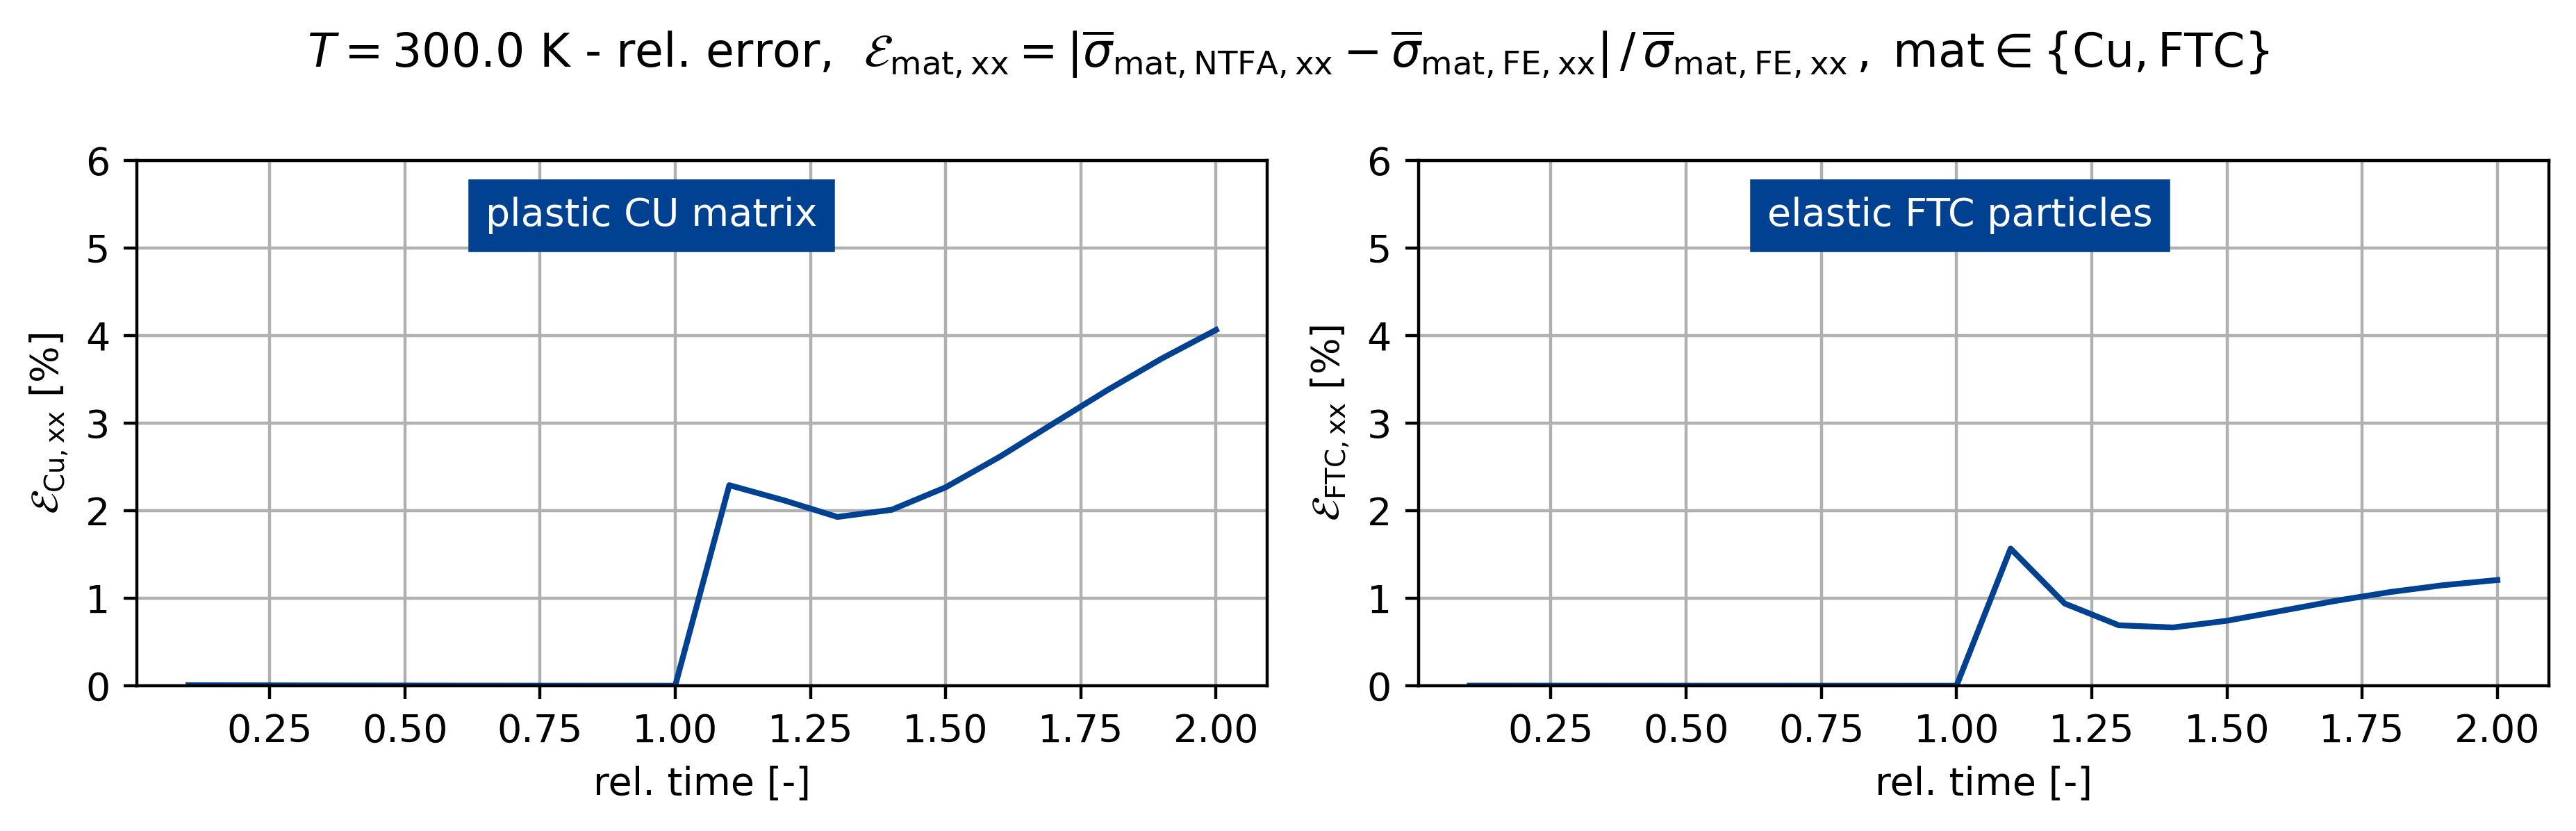

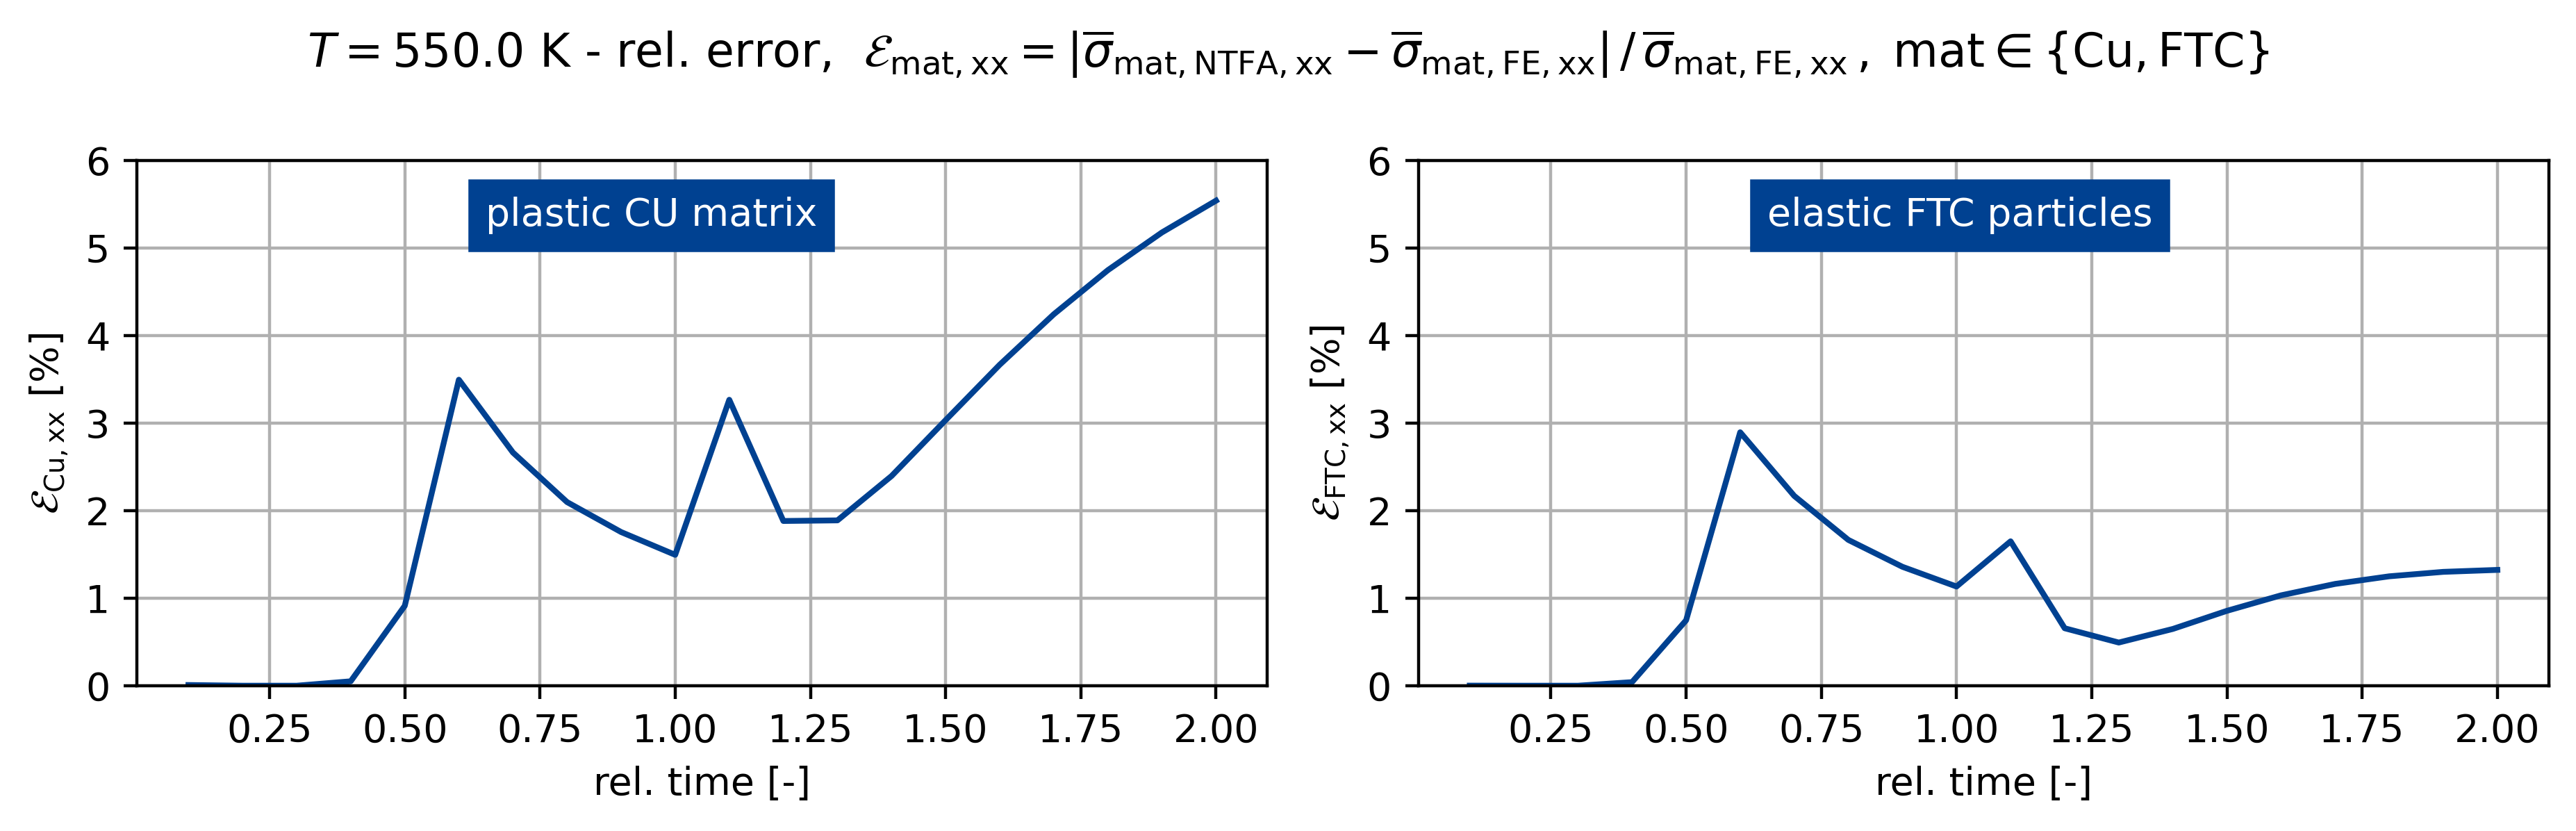

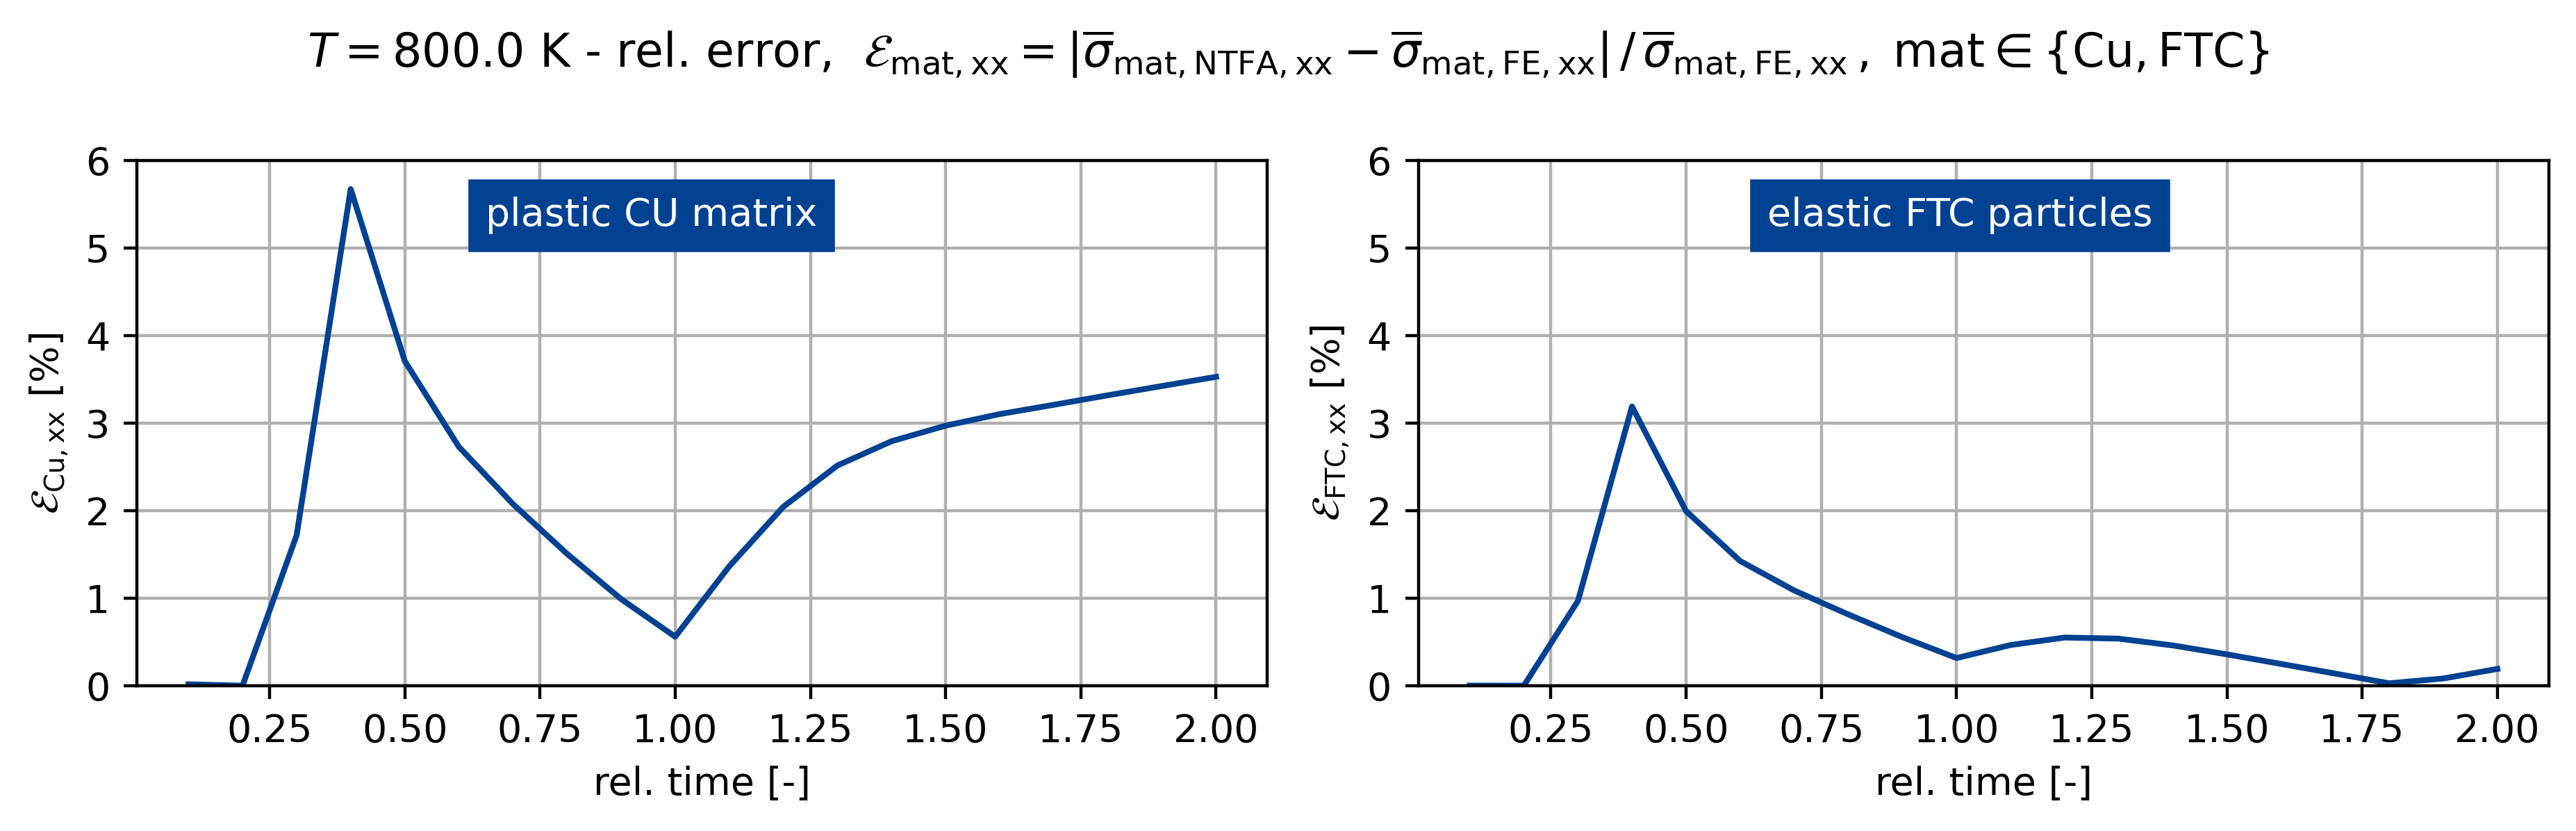

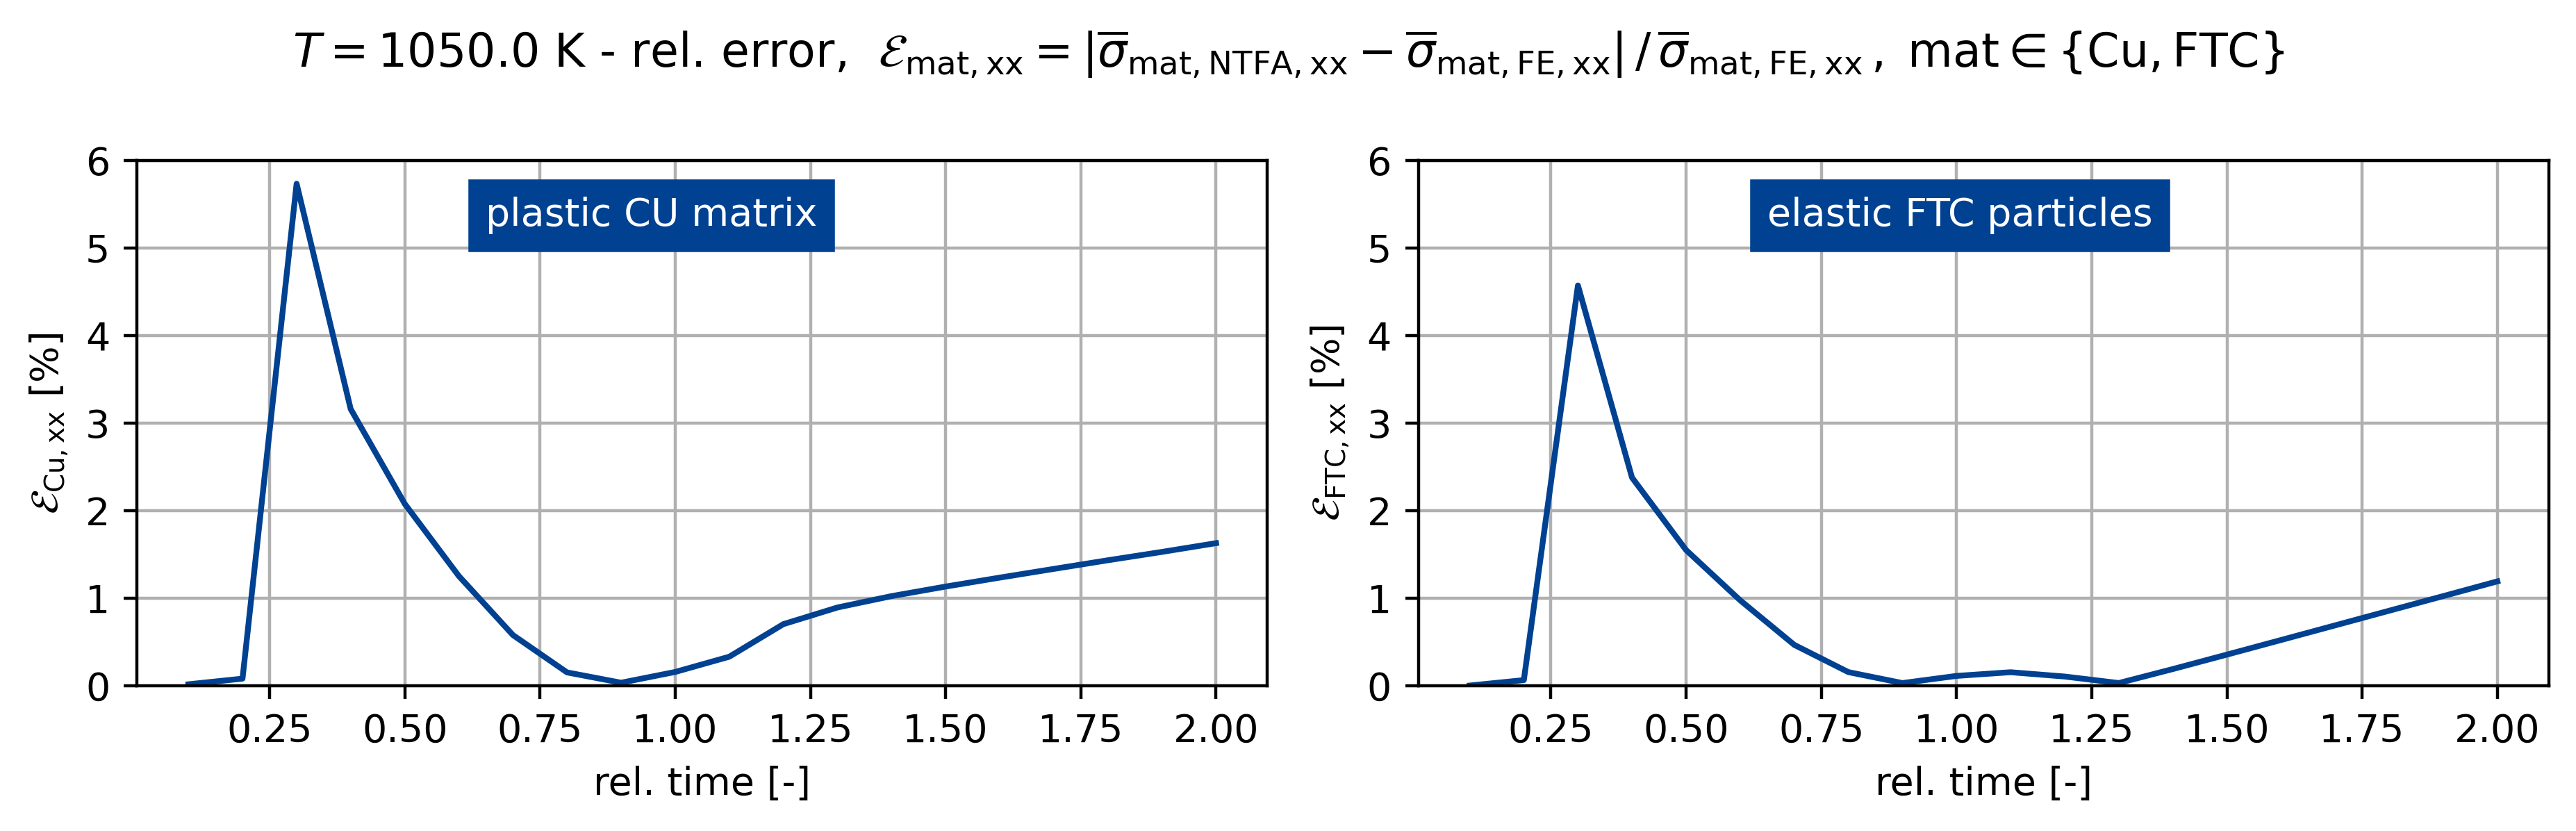

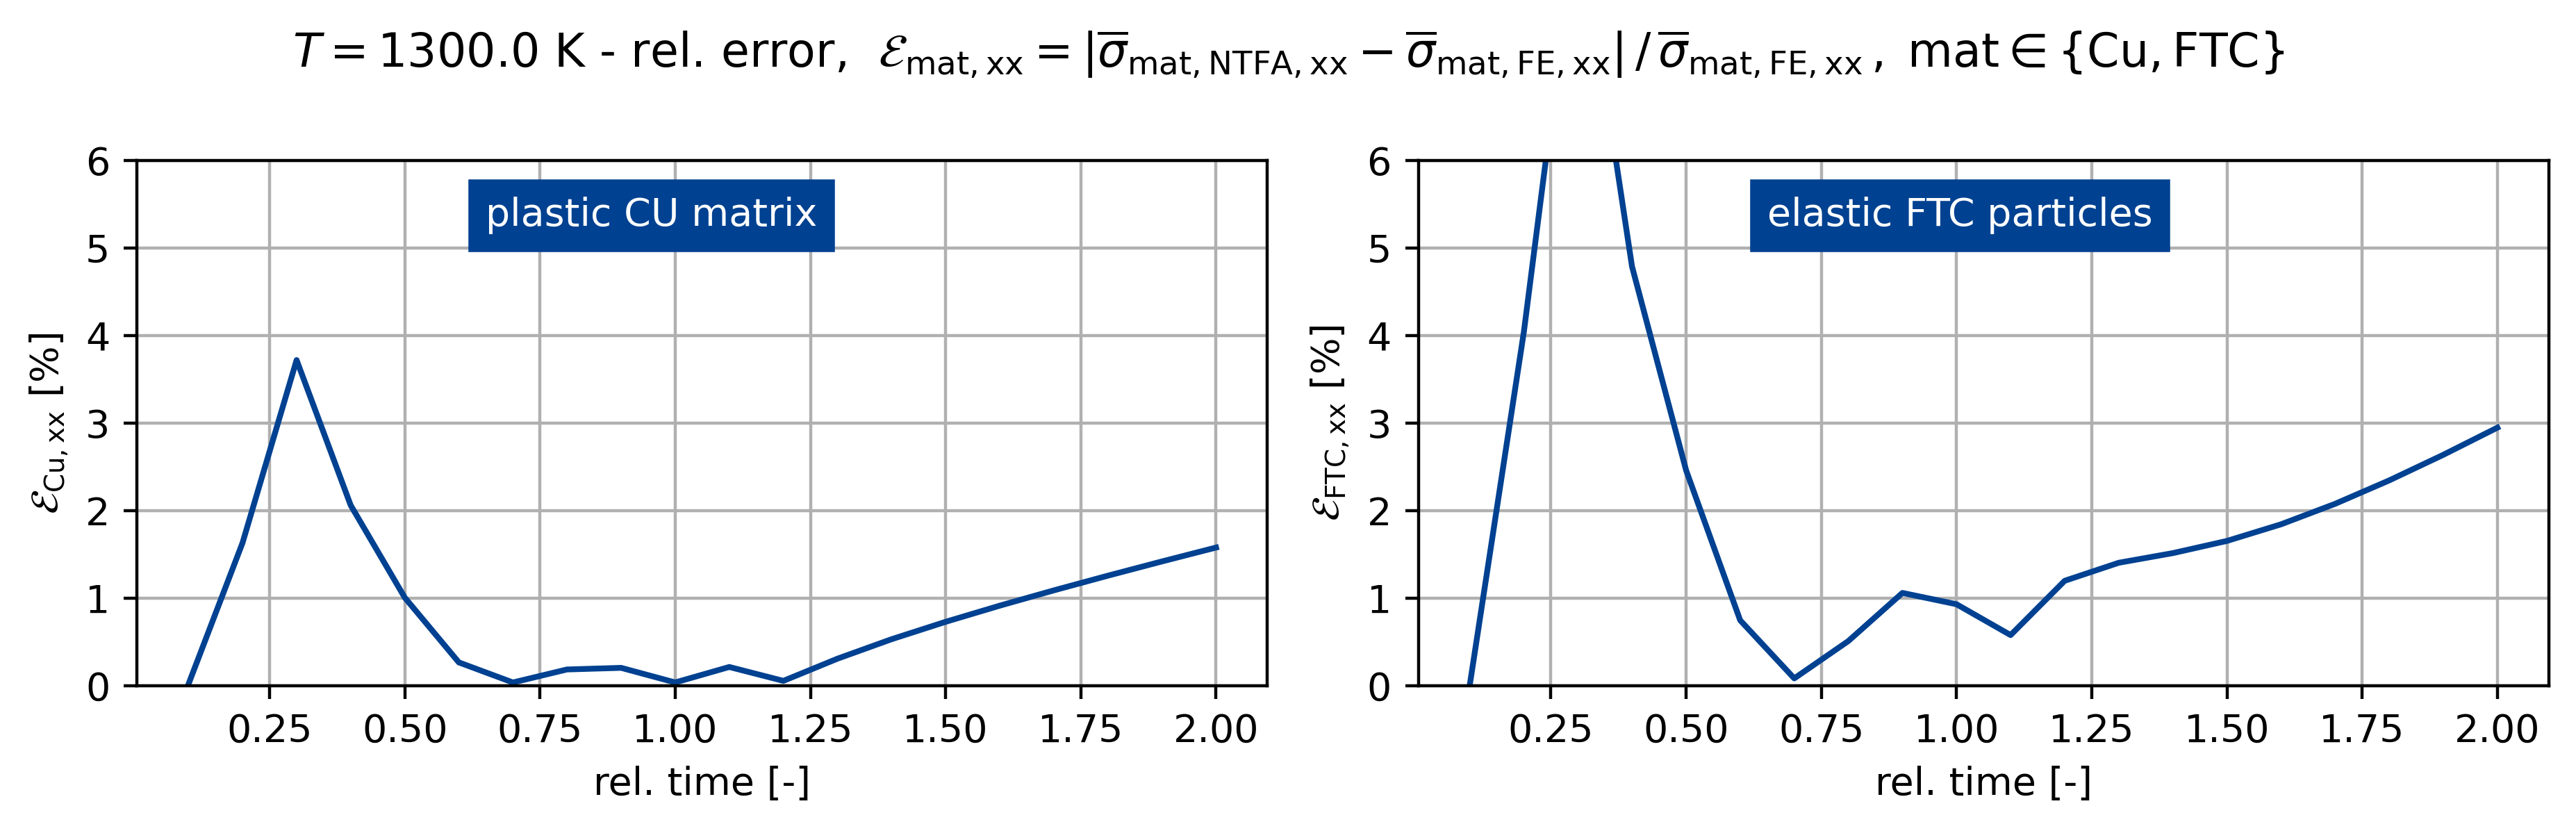

In [14]:
def rel_error(A, A_ref, r_min=None):
    if r_min is None:
        return np.linalg.norm(A - A_ref, axis=1) / np.linalg.norm(A_ref, axis=1)
    else:
        return np.linalg.norm(A - A_ref, axis=1) / np.maximum(
            r_min, np.linalg.norm(A_ref, axis=1)
        )


def rel_error_fixed(A, A_ref, r):
    return np.linalg.norm(A - A_ref, axis=1) / r


sig_fe_list = []
sig0_fe_list = []
sig1_fe_list = []

with h5py.File(
    os.path.join(data_path, "ms9p_uniaxial_stress_data_mod_fe.h5"), "r"
) as F:
    for k in [0, 1, 2, 3, 4]:
        temp = theta_list[np.mod(k, 5)]
        iload = int(k / 5)
        sig_fe = np.array(F[f"loading{iload}/ntfa_T{temp:06.1f}/fe_sig"])
        sig0_fe = np.array(F[f"loading{iload}/ntfa_T{temp:06.1f}/fe_sig0"])
        sig1_fe = np.array(F[f"loading{iload}/ntfa_T{temp:06.1f}/fe_sig1"])
        sig_fe_list.append(sig_fe)
        sig0_fe_list.append(sig0_fe)
        sig1_fe_list.append(sig1_fe)

        fig, ax = plt.subplots(1, 2, figsize=(plot_width, 3.0))
        sig_ref = np.max(np.abs(sig_fe[:, iload]))
        sig_ref0 = np.max(np.abs(sig0_fe[:, iload]))
        sig_ref1 = np.max(np.abs(sig1_fe[:, iload]))
        fig.suptitle(
            rf"$T={temp}$ K - rel. error,  $\mathcal{E}_\mathsf{{mat,xx}} = "
            + r"\vert \overline{\sigma}_\mathsf{mat,NTFA,xx} - \overline{\sigma}_\mathsf{mat,FE,xx} \vert \,/ \, "
            + r"\overline{\sigma}_\mathsf{{mat,FE,xx}} \,, \; \mathsf{mat} \in \{\mathsf{Cu}, \mathsf{FTC} \}$"
        )
        c1 = ntfa_material.v_frac[0]
        c2 = ntfa_material.v_frac[1]
        sig_list[k] = c1 * sig0_list[k] + c2 * sig1_list[k]
        err_sig = np.abs(sig_list[k][:, iload] - sig_fe[:, iload]) / sig_ref
        err_sig0 = np.abs(sig0_list[k][:, iload] - sig0_fe[:, iload]) / sig_ref0
        err_sig1 = np.abs(sig1_list[k][:, iload] - sig1_fe[:, iload]) / sig_ref1
        t = np.linspace(0, 2, sig_list[k][:].shape[0] + 1)[1:]
        ax[0].plot(t[:], err_sig0[:] * 100)
        ax[1].plot(t[:], err_sig1[:] * 100)
        for z, A in enumerate(ax.ravel()):
            A.grid()
            A.set_xlabel("rel. time [-]")
            if z == 0:
                A.set_ylabel(r"$\mathcal{E}_\mathsf{{Cu,xx}}$ [%]")
            else:
                A.set_ylabel(r"$\mathcal{E}_\mathsf{{FTC,xx}}$ [%]")
            A.set_ylim([0, 6])
        ax[0].text(
            0.65, 5.25, "plastic CU matrix", backgroundcolor=colors[0], color="white"
        )
        ax[1].text(
            0.65,
            5.25,
            "elastic FTC particles",
            backgroundcolor=colors[0],
            color="white",
        )
        fig.tight_layout()
        plt.savefig(
            os.path.join(data_path, "figures", f"rel_error_uniaxial_T{temp:.0f}.pdf")
        )

### Figuring when plasticity kicks in using the mixed UMAT

1. set the stress to 0
2. ramp the temperature from 293K
3. check for q >= q_crit_0, q_crit_1, e.g. q_crit_0 = 0.002 (i.e. 0.2%)
4. draw the results of theta

In [15]:
n_ramp = 1300 - 293 + 1
thermal_rampup_file = os.path.join(data_path, "loadcases", "ms9p_thermal_rampup.h5")
with h5py.File(thermal_rampup_file, "w") as F:
    eps_idx = None
    sig_idx = np.arange(6)
    eps = np.zeros(6)
    # the actual loading we are seeking:
    eps_bc = np.zeros((n_ramp, 6))

    # part 1: ramp up theta from 293 K to theta
    T = np.linspace(293.0, 1300.0, n_ramp)
    q = 0.0
    C = np.zeros((6, 6))
    np.set_printoptions(formatter=dict(float=lambda x: "%10.3g" % x))
    eps = np.zeros_like(eps_bc)
    sig = np.zeros_like(eps)
    sig0 = np.zeros_like(eps)
    sig1 = np.zeros_like(eps)
    xi = np.zeros((eps.shape[0], ntfa_material.n_modes))
    q = np.zeros(eps.shape[0])
    q_n = 0.0
    xi_n = np.zeros(ntfa_material.n_modes)
    for i in range(eps.shape[0]):
        t = T[i]
        if i == 0:
            deps = eps_bc[0].copy()
            eps_n = np.zeros(6)
        else:
            deps = eps_bc[i] - eps[i - 1]
            eps_n = eps[i - 1]
        eps[i], sig[i], C, q[i], xi[i] = ntfa_material.UMAT_mixed(
            eps_idx, eps_n, deps, np.zeros(6), t, q_n, xi_n
        )
        xi_n = xi[i].copy()
        q_n = q[i]
        sig0[i] = ntfa_material.stress(eps[i], t, xi[i], i_phase=0)
        sig1[i] = ntfa_material.stress(eps[i], t, xi[i], i_phase=1)

    F.create_dataset("T", data=T)
    F.create_dataset("eps", data=eps)
    F.create_dataset("sig", data=sig)
    F.create_dataset("sig0", data=sig0)
    F.create_dataset("sig1", data=sig1)
    F.create_dataset("q", data=q)
    F.create_dataset("xi", data=xi)

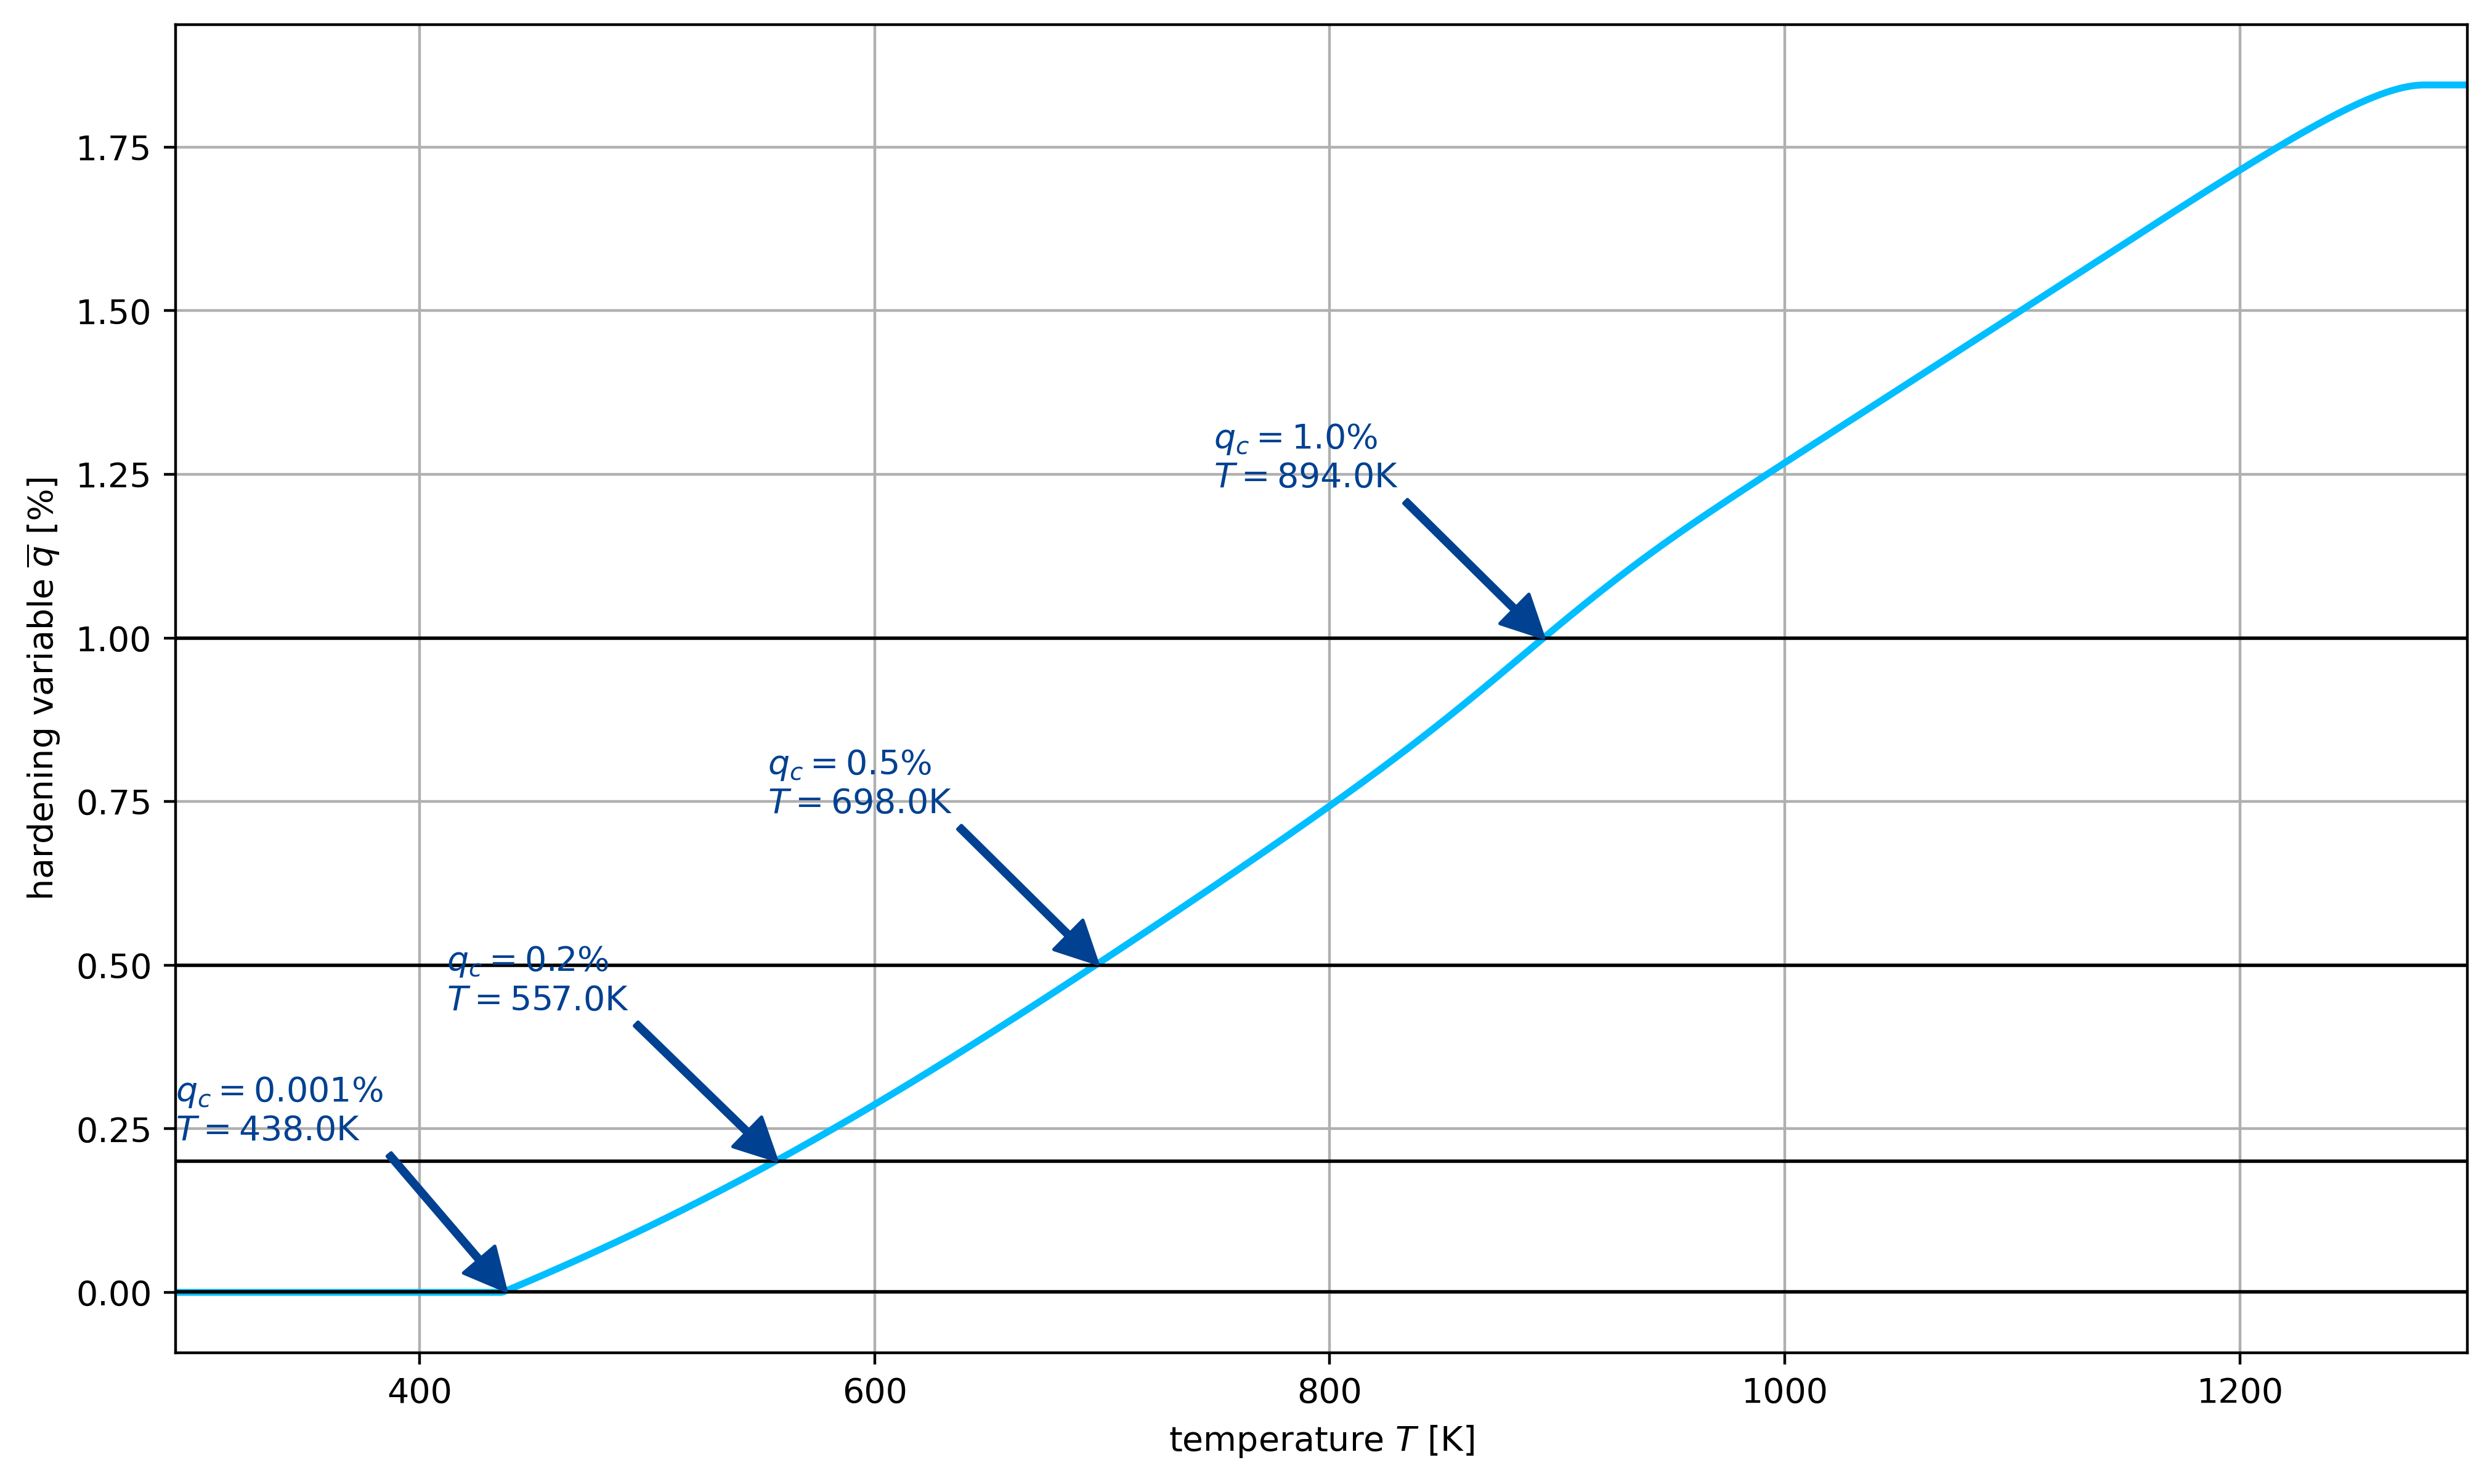

In [16]:
q_crit = [1e-5, 0.002, 0.005, 0.01]
with h5py.File(thermal_rampup_file, "r") as F:
    q = np.array(F["q"])
    T = np.array(F["T"])
    eps = np.array(F["eps"])
    sig0 = np.array(F["sig0"])
    sig1 = np.array(F["sig1"])
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.plot(T, 100 * q, color=colors[1], lw=2, label=r"NTFA $\overline{q}$", marker="")
    for qc in q_crit:
        ax.plot([T[0], T[-1]], [100 * qc, 100 * qc], color="black", lw=1, marker="")
        i = np.searchsorted(q, qc)
        ax.annotate(
            text=rf"$q_c={qc*100}\%$\n$T={T[i]}\mathrm{{K}}$",
            xy=[T[i], 100 * q[i]],
            xytext=[T[i] - 145, 100 * q[i] + 0.23],
            color=colors[0],
            arrowprops={"width": 1.5, "color": colors[0]},
            zorder=100000,
        )

ax.grid()
ax.set_xlim(T[0], T[-1])
ax.set_xlabel(r"temperature $T$ [$\mathrm{K}$]")
ax.set_ylabel(r"hardening variable $\overline{q}$ [%]")
plt.show()

## Twoscale simulation

Analysis of the two-scale simulation
- determine an element in the notch
- extract the strain, temperature, stress, qbar, xi, sig_cu, sig_ftc history
- pass the strain, temperature history to FANS as BC
- Compare the results

In [17]:
fe_fine_file = os.path.join(data_path, "results", "NTFA293K_fine_temp_293-800.h5")
with h5py.File(fe_fine_file, "r") as F:
    # step 1: find the element with the crucial pieces of information
    # read mesh
    vx = np.array(F["/mesh/X"]).reshape((-1, 3))
    el = np.array(F["/mesh/el_vx_idx"]).reshape((-1, 10))
    n_el = np.array(F["/mesh/n_el"])[0]
    n_vx = np.array(F["/mesh/n_vx"])[0]
    gp_idx = np.array(F["/mesh/DPIdx"])

    # get element centers
    el_center = np.zeros((n_el, 3))
    for i_el in range(n_el):
        el_center[i_el, :] = np.mean(vx[el[i_el, :], :], axis=0)

    # find the element center closest to 0., 2.5, 0.
    dist = np.linalg.norm(el_center - np.array([5.0, 0, 2.5])[None, :], axis=1)
    i_min = np.argmin(dist)
    print(
        f"element closest to [5., 0., 2.5]: {i_min} with element center {el_center[i_min]}"
    )

element closest to [5., 0., 2.5]: 10819 with element center [      4.42       -0.5        2.5]


### Load results of simulation on the macroscale with NTFA material model

In the following, we look at the simulation results at the integration point
at the vicinity of the noth (at the center of the specimen)

In [18]:
with h5py.File(fe_fine_file, "r") as F:
    N_modes = 24
    n_inc = 32
    theta = np.zeros(n_inc + 1)
    eps = np.zeros((n_inc + 1, 6))
    sig = np.zeros((n_inc + 1, 6))
    sig_cu = np.zeros((n_inc + 1, 6))
    sig_ftc = np.zeros((n_inc + 1, 6))
    qbar = np.zeros(n_inc + 1)
    xi = np.zeros((n_inc + 1, N_modes))
    zeta = np.zeros((n_inc + 1, N_modes + 7))
    idat_start = np.array(F["/Data/step1/n_iD"][: gp_idx[i_min]]).sum()
    idat_end = idat_start + F["/Data/step1/n_iD"][gp_idx[i_min]]
    n_gp = F["/Data/step1/n_gp"][0]
    theta = np.array(F[f"/temperature{n_inc}"])
    force = np.array(F[f"/force{n_inc}"])
    for i in range(n_inc):
        j = i + 1
        cdat = np.array(F[f"/Data/step{i+1}/cData"][gp_idx[i_min]])
        eps[j, :] = cdat[:6]
        sig[j, :] = cdat[6:]
        idat = np.array(F[f"/Data/step{i+1}/iData"])[idat_start:idat_end]
        xi[j, :] = idat[1 : (N_modes + 1)]
        qbar[j] = idat[0]
        zeta[j, :6] = eps[j, :]
        zeta[j, 6] = 1
        zeta[j, 7:] = xi[j, :]
        # reconstruct the phase-wise stresses
        sig_cu[j, :] = A_cu.interpolate(theta[j]) @ zeta[j, :]
        sig_ftc[j, :] = A_ftc.interpolate(theta[j]) @ zeta[j, :]

### Use temperature and strain as boundary conditions for FE simulation on the microscale

Save the temperature `theta` and strain `eps` from the macroscopic simulation to an HDF5 (`.h5`) file.
This information is then read by an in-house simulation software that performs a FE simulation
on the microscale for this specific integration point.
Therein, `theta` and `eps` from the macroscopic simulation are used as boundary conditions/loadings.

In [19]:
bc_file_name = os.path.join(data_path, "loadcases", "twoscale_notch.h5")
F = h5py.File(bc_file_name, "w")
F.create_dataset("/sig", data=sig)  # only used for comparison later on
F.create_dataset("/sig_cu", data=sig_cu)  # only used for comparison later on
F.create_dataset("/sig_ftc", data=sig_ftc)  # only used for comparison later on
F.create_dataset("/eps", data=eps)
F.create_dataset("/theta", data=theta)
F.create_dataset("/time", data=t)
F.close()

### Load results from FE simulation on the microscale

The in-house FE simulation software stores the simulation results
(homogenized overall stress `sig`, homogenized stress in cu phase `sig_cu`,
homogenized stress in ftc phase `sig_ftc`, and homogenized hardening variable `qbar`)
on the microscale in a new HDF5 (`.h5`) file.
These results serve as validation data for the two-scale simulation at
the specific integration point of the macroscale simulation.

In [20]:
sim_bc_file_name = os.path.join(data_path, "results", "twoscale_notch_rve.h5")
with h5py.File(sim_bc_file_name, "r") as F:
    fe_eps = np.array(F["/eps"])
    fe_theta = np.array(F["/theta"])
    fe_sig = np.array(F["/rve/sig"])
    fe_sig_cu = np.array(F["/rve/sig0"])
    fe_sig_ftc = np.array(F["/rve/sig1"])
    fe_qbar = np.array(F["/rve/qbar"]).ravel()

#### Compute some stress information (hydrostatic stress, equivalent stress, principal normal stresses)

In [21]:
sig_h = sig[:, :3].sum(axis=1) / 3
sig_h_cu = sig_cu[:, :3].sum(axis=1) / 3
sig_h_ftc = sig_ftc[:, :3].sum(axis=1) / 3
fe_sig_h = fe_sig[:, :3].sum(axis=1) / 3
fe_sig_h_cu = fe_sig_cu[:, :3].sum(axis=1) / 3
fe_sig_h_ftc = fe_sig_ftc[:, :3].sum(axis=1) / 3

sig_eq = np.sqrt(
    1.5 * np.maximum(0.0, np.linalg.norm(sig, axis=1) ** 2 - 3 * sig_h * sig_h)
)
sig_eq_cu = np.sqrt(
    1.5 * np.maximum(0.0, np.linalg.norm(sig_cu, axis=1) ** 2 - 3 * sig_h_cu * sig_h_cu)
)
sig_eq_ftc = np.sqrt(
    1.5
    * np.maximum(0.0, np.linalg.norm(sig_ftc, axis=1) ** 2 - 3 * sig_h_ftc * sig_h_ftc)
)
fe_sig_eq = np.sqrt(
    1.5 * np.maximum(0.0, np.linalg.norm(fe_sig, axis=1) ** 2 - 3 * sig_h * sig_h)
)
fe_sig_eq_cu = np.sqrt(
    1.5
    * np.maximum(
        0.0, np.linalg.norm(fe_sig_cu, axis=1) ** 2 - 3 * fe_sig_h_cu * sig_h_cu
    )
)
fe_sig_eq_ftc = np.sqrt(
    1.5
    * np.maximum(
        0.0, np.linalg.norm(fe_sig_ftc, axis=1) ** 2 - 3 * fe_sig_h_ftc * sig_h_ftc
    )
)

sig_I_ftc = np.zeros(sig.shape[0])
sig_II_ftc = np.zeros(sig.shape[0])
sig_III_ftc = np.zeros(sig.shape[0])
sig_I_cu = np.zeros(sig.shape[0])
sig_II_cu = np.zeros(sig.shape[0])
sig_III_cu = np.zeros(sig.shape[0])
for i in range(n_inc + 1):
    sig_III_cu[i], sig_II_cu[i], sig_I_cu[i] = np.linalg.eigvalsh(Vec2Tensor(sig_cu[i]))
    sig_III_ftc[i], sig_II_ftc[i], sig_I_ftc[i] = np.linalg.eigvalsh(
        Vec2Tensor(sig_ftc[i])
    )

fe_sig_I_ftc = np.zeros(sig.shape[0])
fe_sig_II_ftc = np.zeros(sig.shape[0])
fe_sig_III_ftc = np.zeros(sig.shape[0])
fe_sig_I_cu = np.zeros(sig.shape[0])
fe_sig_II_cu = np.zeros(sig.shape[0])
fe_sig_III_cu = np.zeros(sig.shape[0])
for i in range(n_inc + 1):
    fe_sig_III_cu[i], fe_sig_II_cu[i], fe_sig_I_cu[i] = np.linalg.eigvalsh(
        Vec2Tensor(fe_sig_cu[i])
    )
    fe_sig_III_ftc[i], fe_sig_II_ftc[i], fe_sig_I_ftc[i] = np.linalg.eigvalsh(
        Vec2Tensor(fe_sig_ftc[i])
    )

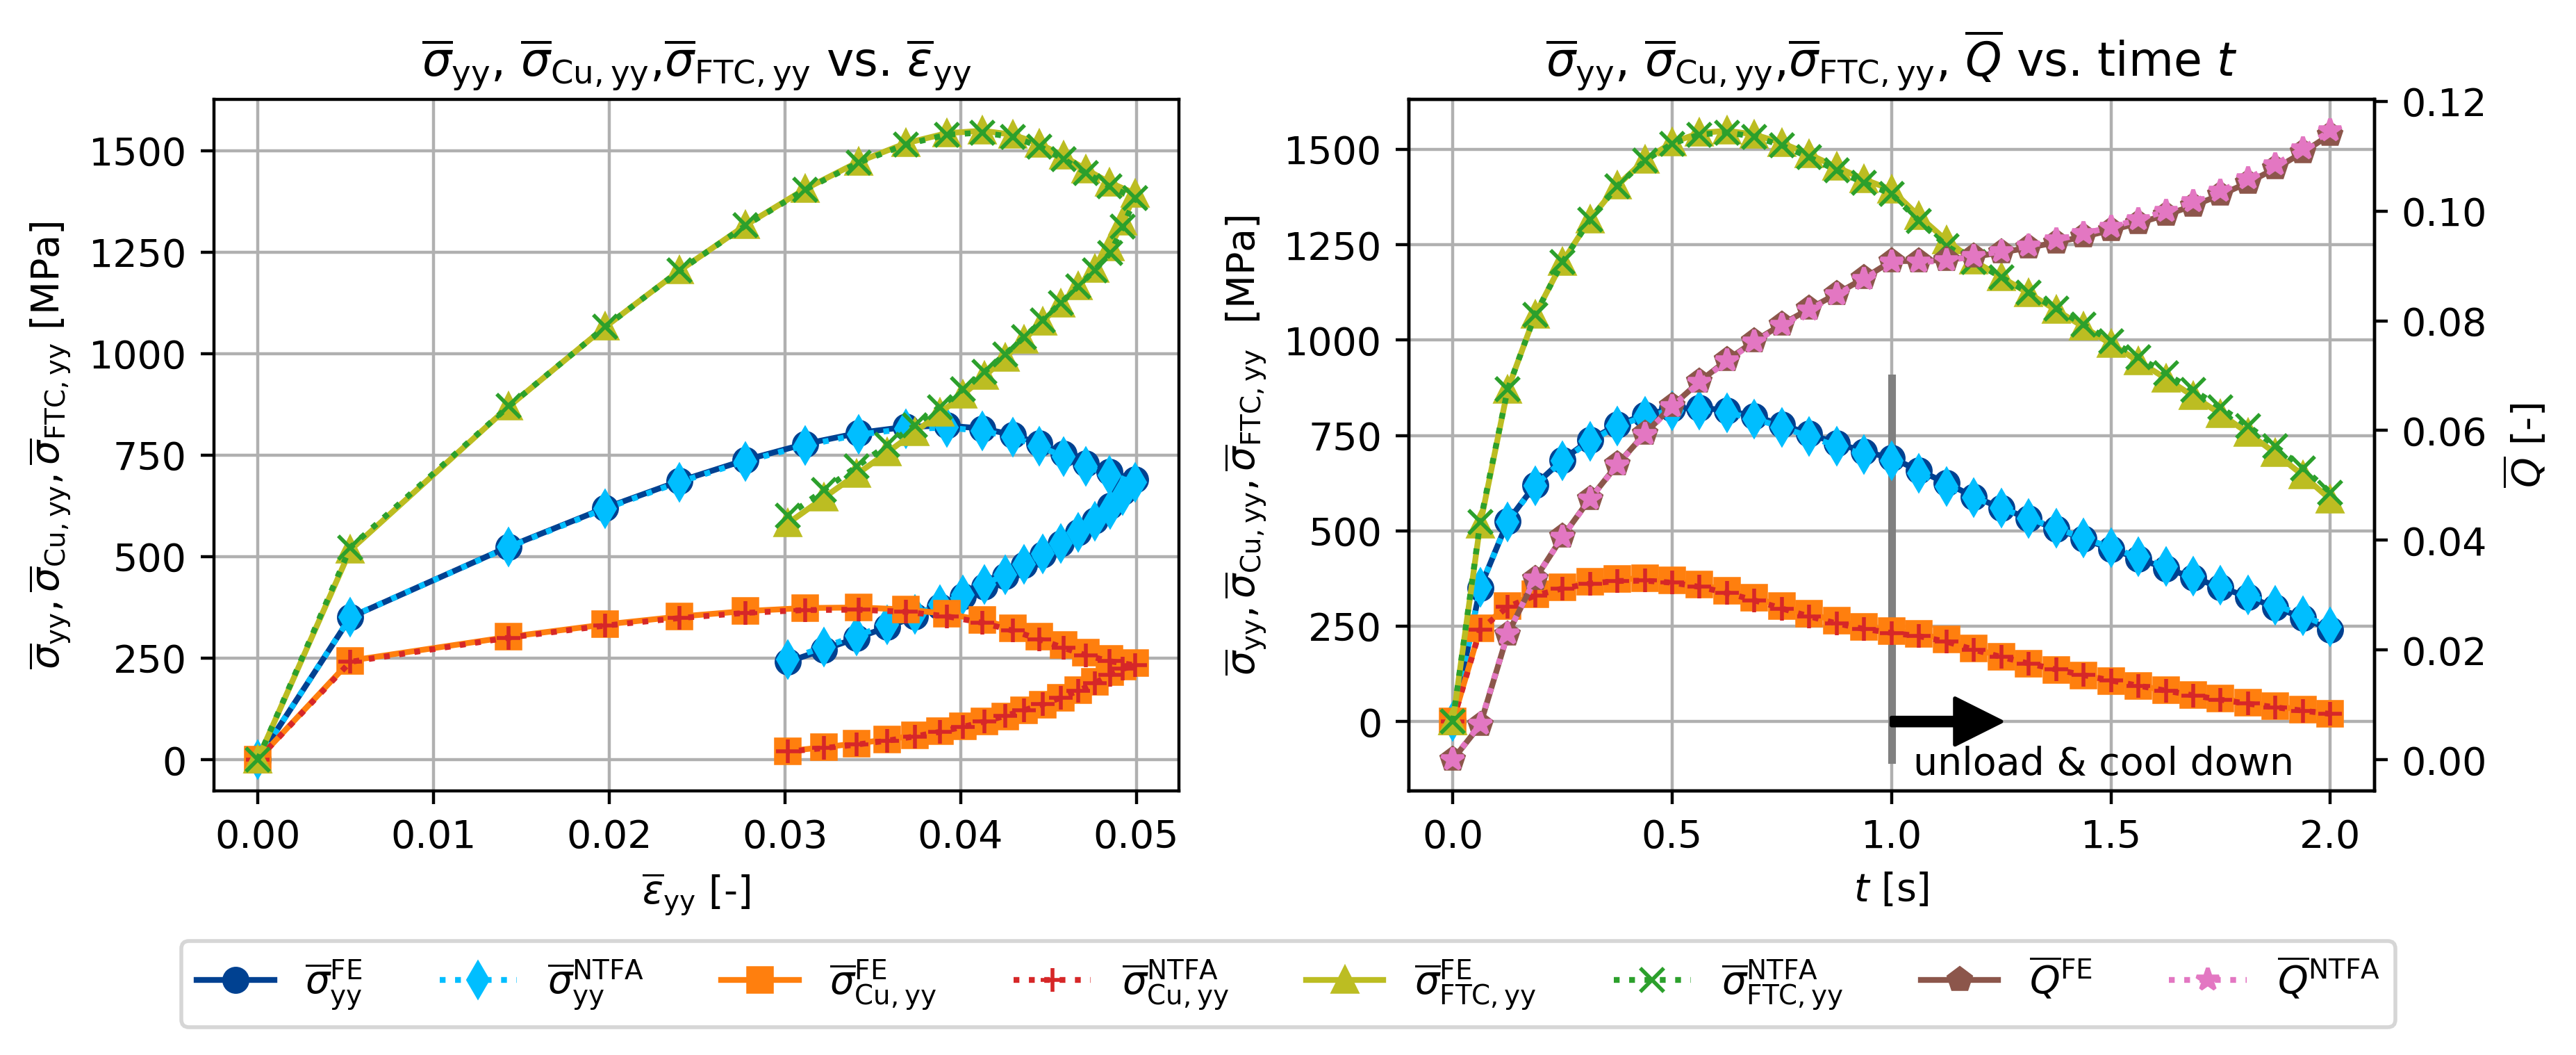

In [22]:
t = np.linspace(0, 2, n_inc + 1)
fig, ax = plt.subplots(1, 2, figsize=(plot_width, 3.5))
ax[0].plot(
    fe_eps[:, 1],
    fe_sig[:, 1] / 1000,
    color=colors[0],
    marker=markers[0],
    label=r"$\overline{\sigma}_{\sf yy}^{\mathrm{FE}}$",
)
ax[0].plot(
    eps[:, 1],
    sig[:, 1] / 1000,
    ":",
    color=colors[1],
    marker=markers[1],
    label=r"$\overline{\sigma}_{\sf yy}^{\mathrm{NTFA}}$",
)
ax[0].plot(
    fe_eps[:, 1],
    fe_sig_cu[:, 1] / 1000,
    "-",
    color=colors[2],
    marker=markers[2],
    label=r"$\overline{\sigma}_{\sf Cu, yy}^{\mathrm{FE}}$",
)
ax[0].plot(
    eps[:, 1],
    sig_cu[:, 1] / 1000,
    ":",
    color=colors[3],
    marker=markers[3],
    label=r"$\overline{\sigma}_{\sf Cu, yy}^{\mathrm{NTFA}}$",
)
ax[0].plot(
    fe_eps[:, 1],
    fe_sig_ftc[:, 1] / 1000,
    "-",
    color=colors[4],
    marker=markers[4],
    label=r"$\overline{\sigma}_{\sf FTC, yy}^{\mathrm{FE}}$",
)
ax[0].plot(
    eps[:, 1],
    sig_ftc[:, 1] / 1000,
    ":",
    color=colors[5],
    marker=markers[5],
    label=r"$\overline{\sigma}_{\sf FTC, yy}^{\mathrm{NTFA}}$",
)
ax[0].set_title(
    r"$\overline{\sigma}_{\sf yy}$, $\overline{\sigma}_{\sf Cu, yy}$,"
    + r"$\overline{\sigma}_{\sf FTC, yy}$ vs. $\overline{\varepsilon}_{\sf yy}$"
)
# ax[0].legend()
ax[0].grid()
ax[0].set_xlabel(r"$\overline{\varepsilon}_{\sf yy}$ [-]")
ax[0].set_ylabel(
    r"$\overline{\sigma}_{\sf yy}, \overline{\sigma}_{\sf Cu, yy}, \overline{\sigma}_{\sf FTC, yy}$ [MPa]"
)
eyy_max = max(eps[:, 1])
syy = sig[int(n_inc / 2), 1] / 1000
syy_cu = sig_cu[int(n_inc / 2), 1] / 1000
syy_ftc = sig_ftc[int(n_inc / 2), 1] / 1000
# arrowprops = dict(shrink=0.02, facecolor='black', shrinkB=1, width=2, headwidth=12, headlength=12)
arrowprops = dict(arrowstyle="-|>", shrinkB=1, shrinkA=50)
# ax[0].annotate("start\nunloading &\ncool down", xy=(eyy_max,syy), xytext=(0.02,925), arrowprops=arrowprops)
# ax[0].annotate("", xy=(eyy_max, syy_cu), xytext=(0.0275, 975), arrowprops=arrowprops)
# ax[0].annotate("", xy=(eyy_max, syy_ftc), xytext=(0.0315, 1050), arrowprops=arrowprops)
# ax[0].plot(eyy_max, syy_cu, "d", color="red", ms=10)
# ax[0].plot(eyy_max, syy_ftc, "d", color="blue", ms=10)
# ax[0].plot(eyy_max, syy, "d", color="black", ms=10)

ax[1].plot((1, 1), (-100, 900), lw=2, color="gray")
ax[1].text(1.05, -140, "unload & cool down")
ax[1].annotate(
    "",
    xy=(1.25, 0),
    xytext=(1, 0),
    arrowprops=dict(
        facecolor="black", shrink=0.0, width=2, headwidth=12, headlength=12
    ),
)
ax[1].plot(
    t, fe_sig[:, 1] / 1000, "-", color=colors[0], marker=markers[0]
)  # , label=r"$\overline{\sigma}_{\sf yy}^{\mathrm{FE}}$")
ax[1].plot(
    t, sig[:, 1] / 1000, ":", color=colors[1], marker=markers[1]
)  # , label=r"$\overline{\sigma}_{\sf yy}^{\mathrm{NTFA}}$")
ax[1].plot(
    t, fe_sig_cu[:, 1] / 1000, "-", color=colors[2], marker=markers[2]
)  # , label=r"$\overline{\sigma}_{\sf Cu,yy}^{\mathrm{FE}}$")
ax[1].plot(
    t, sig_cu[:, 1] / 1000, ":", color=colors[3], marker=markers[3]
)  # , label=r"$\overline{\sigma}_{\sf Cu,yy}^{\mathrm{NTFA}}$")
ax[1].plot(
    t, fe_sig_ftc[:, 1] / 1000, "-", color=colors[4], marker=markers[4]
)  # , label=r"$\overline{\sigma}_{\sf FTC,yy}^{\mathrm{FE}}$")
ax[1].plot(
    t, sig_ftc[:, 1] / 1000, ":", color=colors[5], marker=markers[5]
)  # , label=r"$\overline{\sigma}_{\sf FTC,yy}^{\mathrm{NTFA}}$")
ax[1].set_title(
    r"$\overline{\sigma}_{\sf yy}$, $\overline{\sigma}_{\sf Cu, yy}$,"
    + r"$\overline{\sigma}_{\sf FTC, yy}$, $\overline{Q}$ vs. time $t$"
)
ax2 = ax[1].twinx()
ax[1].grid()
ax2.plot(
    t, fe_qbar, "-", color=colors[6], marker="p", label=r"$\overline{Q}^{\mathrm{FE}}$"
)
ax2.plot(
    t,
    qbar,
    ":",
    color=colors[7],
    marker="*",
    label=r"$\overline{Q}^{\mathrm{NTFA}}$",
)
ax[1].set_xlabel(r"$t$ [s]")
ax[1].set_ylabel(
    r"$\overline{\sigma}_{\sf yy}, \overline{\sigma}_{\sf Cu, yy}, \overline{\sigma}_{\sf FTC, yy}$  [MPa]"
)
ax2.set_ylabel(r"$\overline{Q}$ [-]")
# ax[1].legend(loc="center right")
fig.legend(ncol=8, loc="lower center", bbox_to_anchor=(0, -0.09, 1, 1))
plt.tight_layout()
plt.savefig(
    os.path.join(data_path, "figures", "notchtest_fine_sigyy_ntfa.pdf"),
    format="pdf",
    bbox_inches="tight",
)

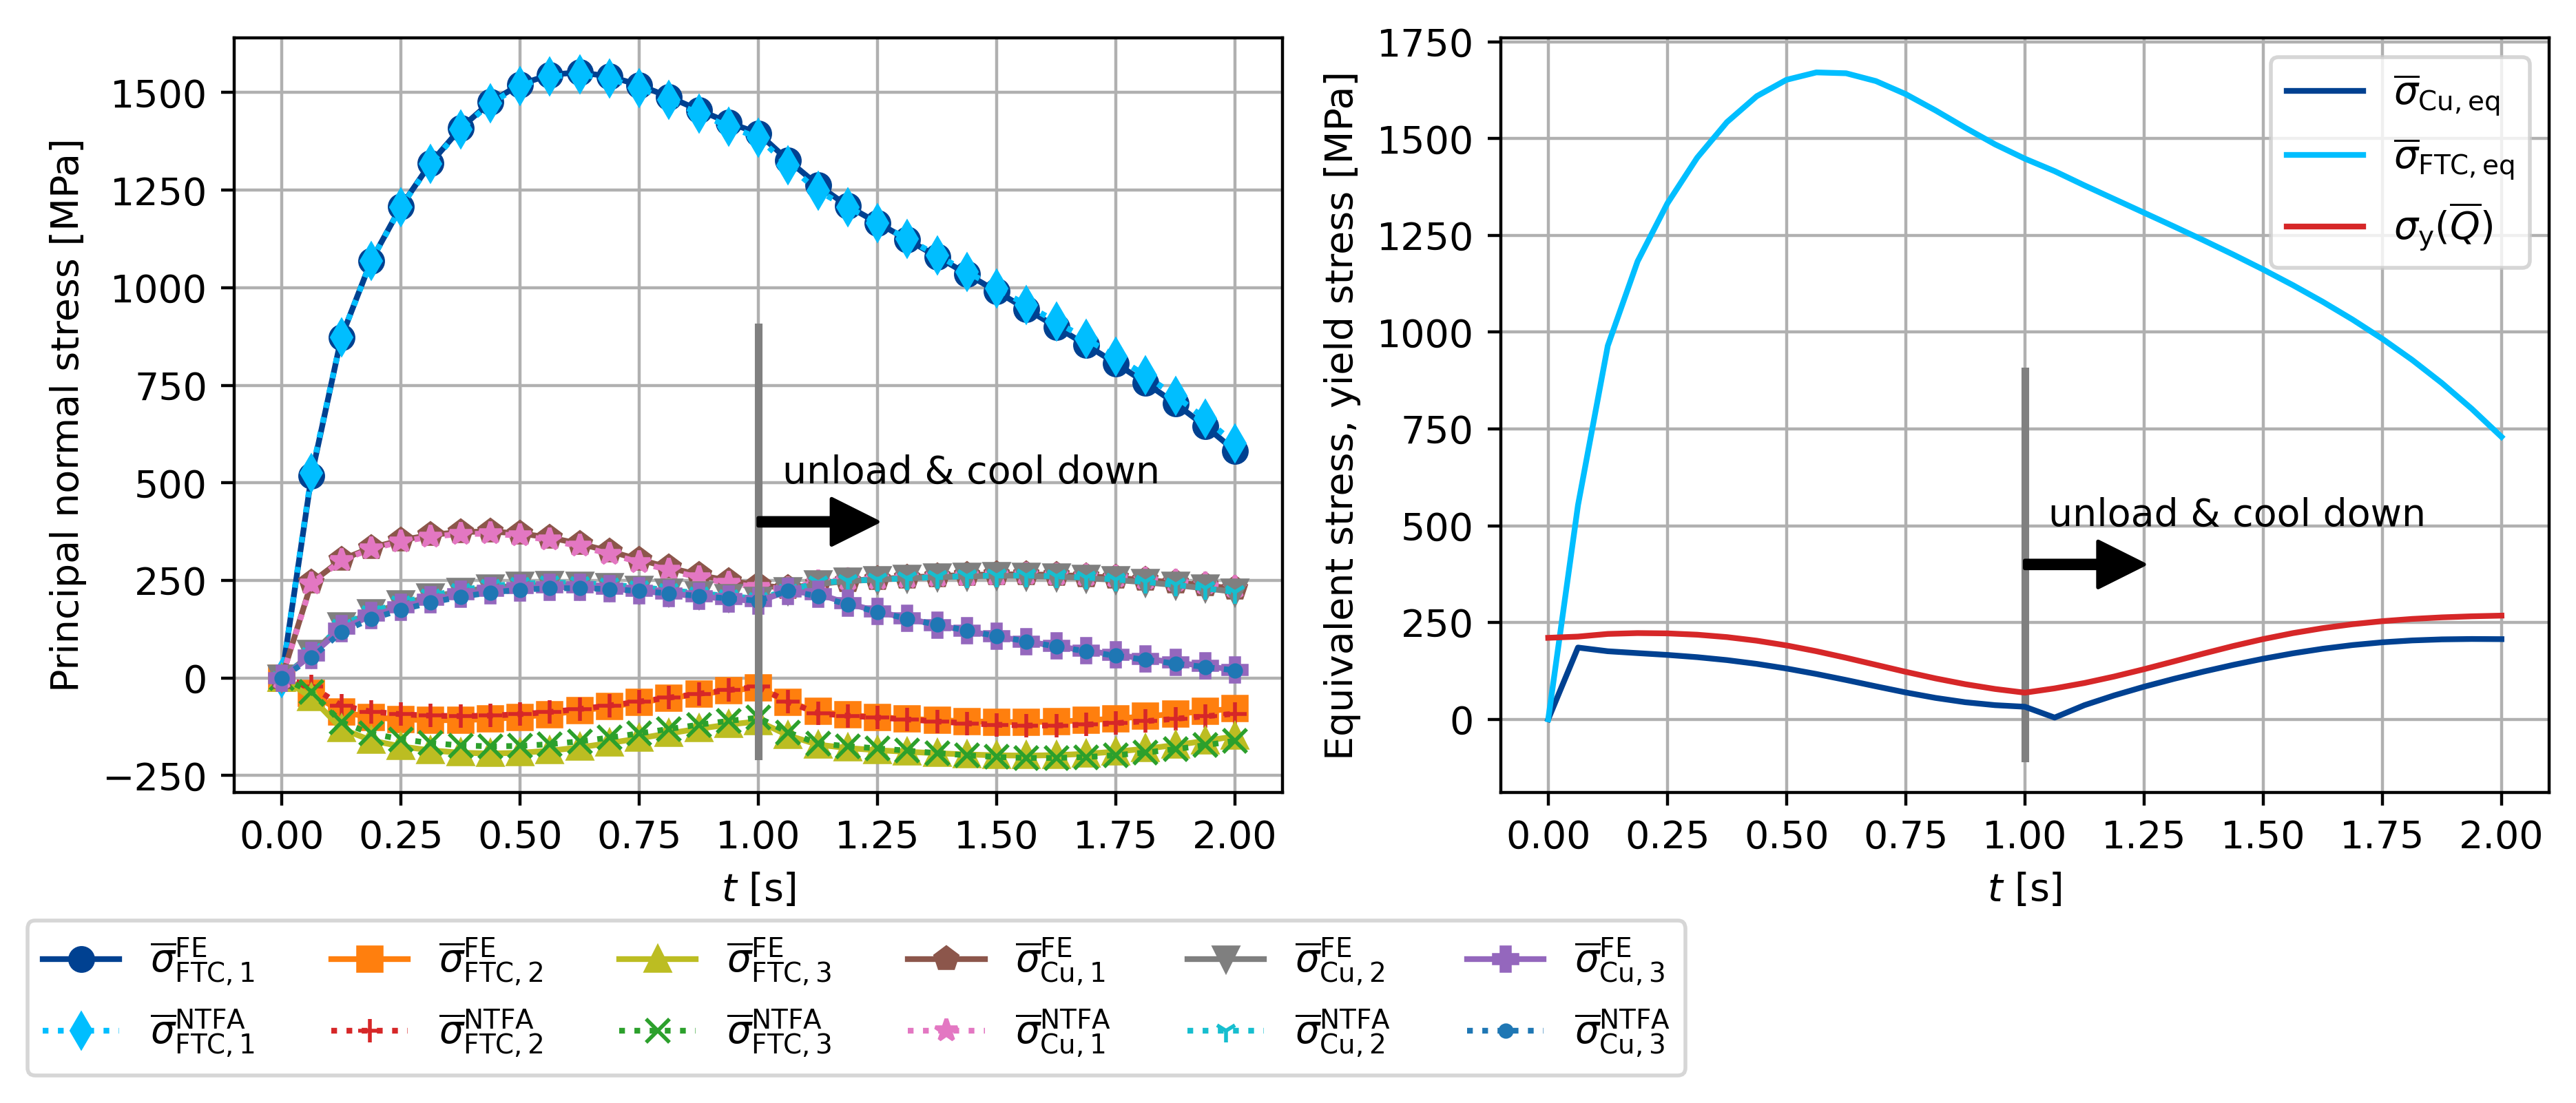

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(plot_width, 3.5))
ax[0].plot(
    t,
    fe_sig_I_ftc / 1000,
    "-",  # fe_sig_III_ftc
    color=colors[0],
    marker=markers[0],
    label=r"$\overline{\sigma}_{\sf FTC, 1}^{\mathrm{FE}}$",
)
ax[0].plot(
    t,
    sig_I_ftc / 1000,
    ":",  # sig_III_ftc
    color=colors[1],
    marker=markers[1],
    label=r"$\overline{\sigma}_{\sf FTC, 1}^{\mathrm{NTFA}}$",
)
ax[0].plot(
    t,
    fe_sig_II_ftc / 1000,
    "-",  # fe_sig_II_ftc
    color=colors[2],
    marker=markers[2],
    label=r"$\overline{\sigma}_{\sf FTC, 2}^{\mathrm{FE}}$",
)
ax[0].plot(
    t,
    sig_II_ftc / 1000,
    ":",  # sig_II_ftc
    color=colors[3],
    marker=markers[3],
    label=r"$\overline{\sigma}_{\sf FTC, 2}^{\mathrm{NTFA}}$",
)
ax[0].plot(
    t,
    fe_sig_III_ftc / 1000,
    "-",  # fe_sig_I_ftc
    color=colors[4],
    marker=markers[4],
    label=r"$\overline{\sigma}_{\sf FTC, 3}^{\mathrm{FE}}$",
)
ax[0].plot(
    t,
    sig_III_ftc / 1000,
    ":",  # sig_I_ftc
    color=colors[5],
    marker=markers[5],
    label=r"$\overline{\sigma}_{\sf FTC, 3}^{\mathrm{NTFA}}$",
)
ax[0].plot(
    t,
    fe_sig_I_cu / 1000,
    "-",  # fe_sig_III_cu
    color=colors[6],
    marker=markers[6],
    label=r"$\overline{\sigma}_{\sf Cu, 1}^{\mathrm{FE}}$",
)
ax[0].plot(
    t,
    sig_I_cu / 1000,
    ":",  # sig_III_cu
    color=colors[7],
    marker=markers[7],
    label=r"$\overline{\sigma}_{\sf Cu, 1}^{\mathrm{NTFA}}$",
)
ax[0].plot(
    t,
    fe_sig_II_cu / 1000,
    "-",  # fe_sig_II_cu
    color=colors[8],
    marker=markers[8],
    label=r"$\overline{\sigma}_{\sf Cu, 2}^{\mathrm{FE}}$",
)
ax[0].plot(
    t,
    sig_II_cu / 1000,
    ":",  # sig_II_cu
    color=colors[9],
    marker=markers[9],
    label=r"$\overline{\sigma}_{\sf Cu, 2}^{\mathrm{NTFA}}$",
)
ax[0].plot(
    t,
    fe_sig_III_cu / 1000,
    "-",  # fe_sig_I_cu
    color=colors[10],
    marker=markers[10],
    label=r"$\overline{\sigma}_{\sf Cu, 3}^{\mathrm{FE}}$",
)
ax[0].plot(
    t,
    sig_III_cu / 1000,
    ":",  # sig_I_cu
    color=colors[11],
    marker=markers[11],
    label=r"$\overline{\sigma}_{\sf Cu, 3}^{\mathrm{NTFA}}$",
)
# ax[0].legend(ncol=1)  # loc='center right')
ax[0].grid()
ax[0].set_xlabel(r"$t$ [s]")
ax[0].set_ylabel(r"Principal normal stress [MPa]")
ax[0].plot((1, 1), (-200, 900), lw=2, color="gray")
ax[0].text(1.05, 500, "unload & cool down")
ax[0].annotate(
    "",
    xy=(1.25, 400),
    xytext=(1, 400),
    arrowprops=dict(
        facecolor="black", shrink=0.0, width=2, headwidth=12, headlength=12
    ),
)
fig.legend(ncol=6, loc="lower left", bbox_to_anchor=(0, -0.15, 1, 1))

sig_y = np.zeros_like(t)
for i, T in enumerate(theta):
    sig_y[i] = my_sig_y(T, qbar[i])

ax[1].plot((1, 1), (-100, 900), lw=2, color="gray")
ax[1].text(1.05, 500, "unload & cool down")
ax[1].annotate(
    "",
    xy=(1.25, 400),
    xytext=(1, 400),
    arrowprops=dict(
        facecolor="black", shrink=0.0, width=2, headwidth=12, headlength=12
    ),
)
# ax[1].plot(t, sig_h_cu/1000, '-', color='red', label=r"$\overline{\sigma}_{\sf Cu, h}$")
ax[1].plot(
    t, sig_eq_cu / 1000, "-", color=colors[0], label=r"$\overline{\sigma}_{\sf Cu, eq}$"
)
# ax[1].plot(t, sig_h_ftc/1000, '-', color='blue', label=r"$\overline{\sigma}_{\sf FTC, h}$")
ax[1].plot(
    t,
    sig_eq_ftc / 1000,
    "-",
    color=colors[1],
    label=r"$\overline{\sigma}_{\sf FTC, eq}$",
)
ax[1].plot(
    t, sig_y / 1000, "-", color=colors[3], label=r"$\sigma_{\sf y}(\overline{Q})$"
)
ax[1].legend(ncol=1, loc="upper right")
ax[1].grid()
ax[1].set_xlabel(r"$t$ [s]")
ax[1].set_ylabel(r"Equivalent stress, yield stress [MPa]")
fig.tight_layout()
fig.savefig(
    os.path.join(data_path, "figures", "notchtest_fine_sigeq_ntfa.pdf"),
    format="pdf",
    bbox_inches="tight",
)

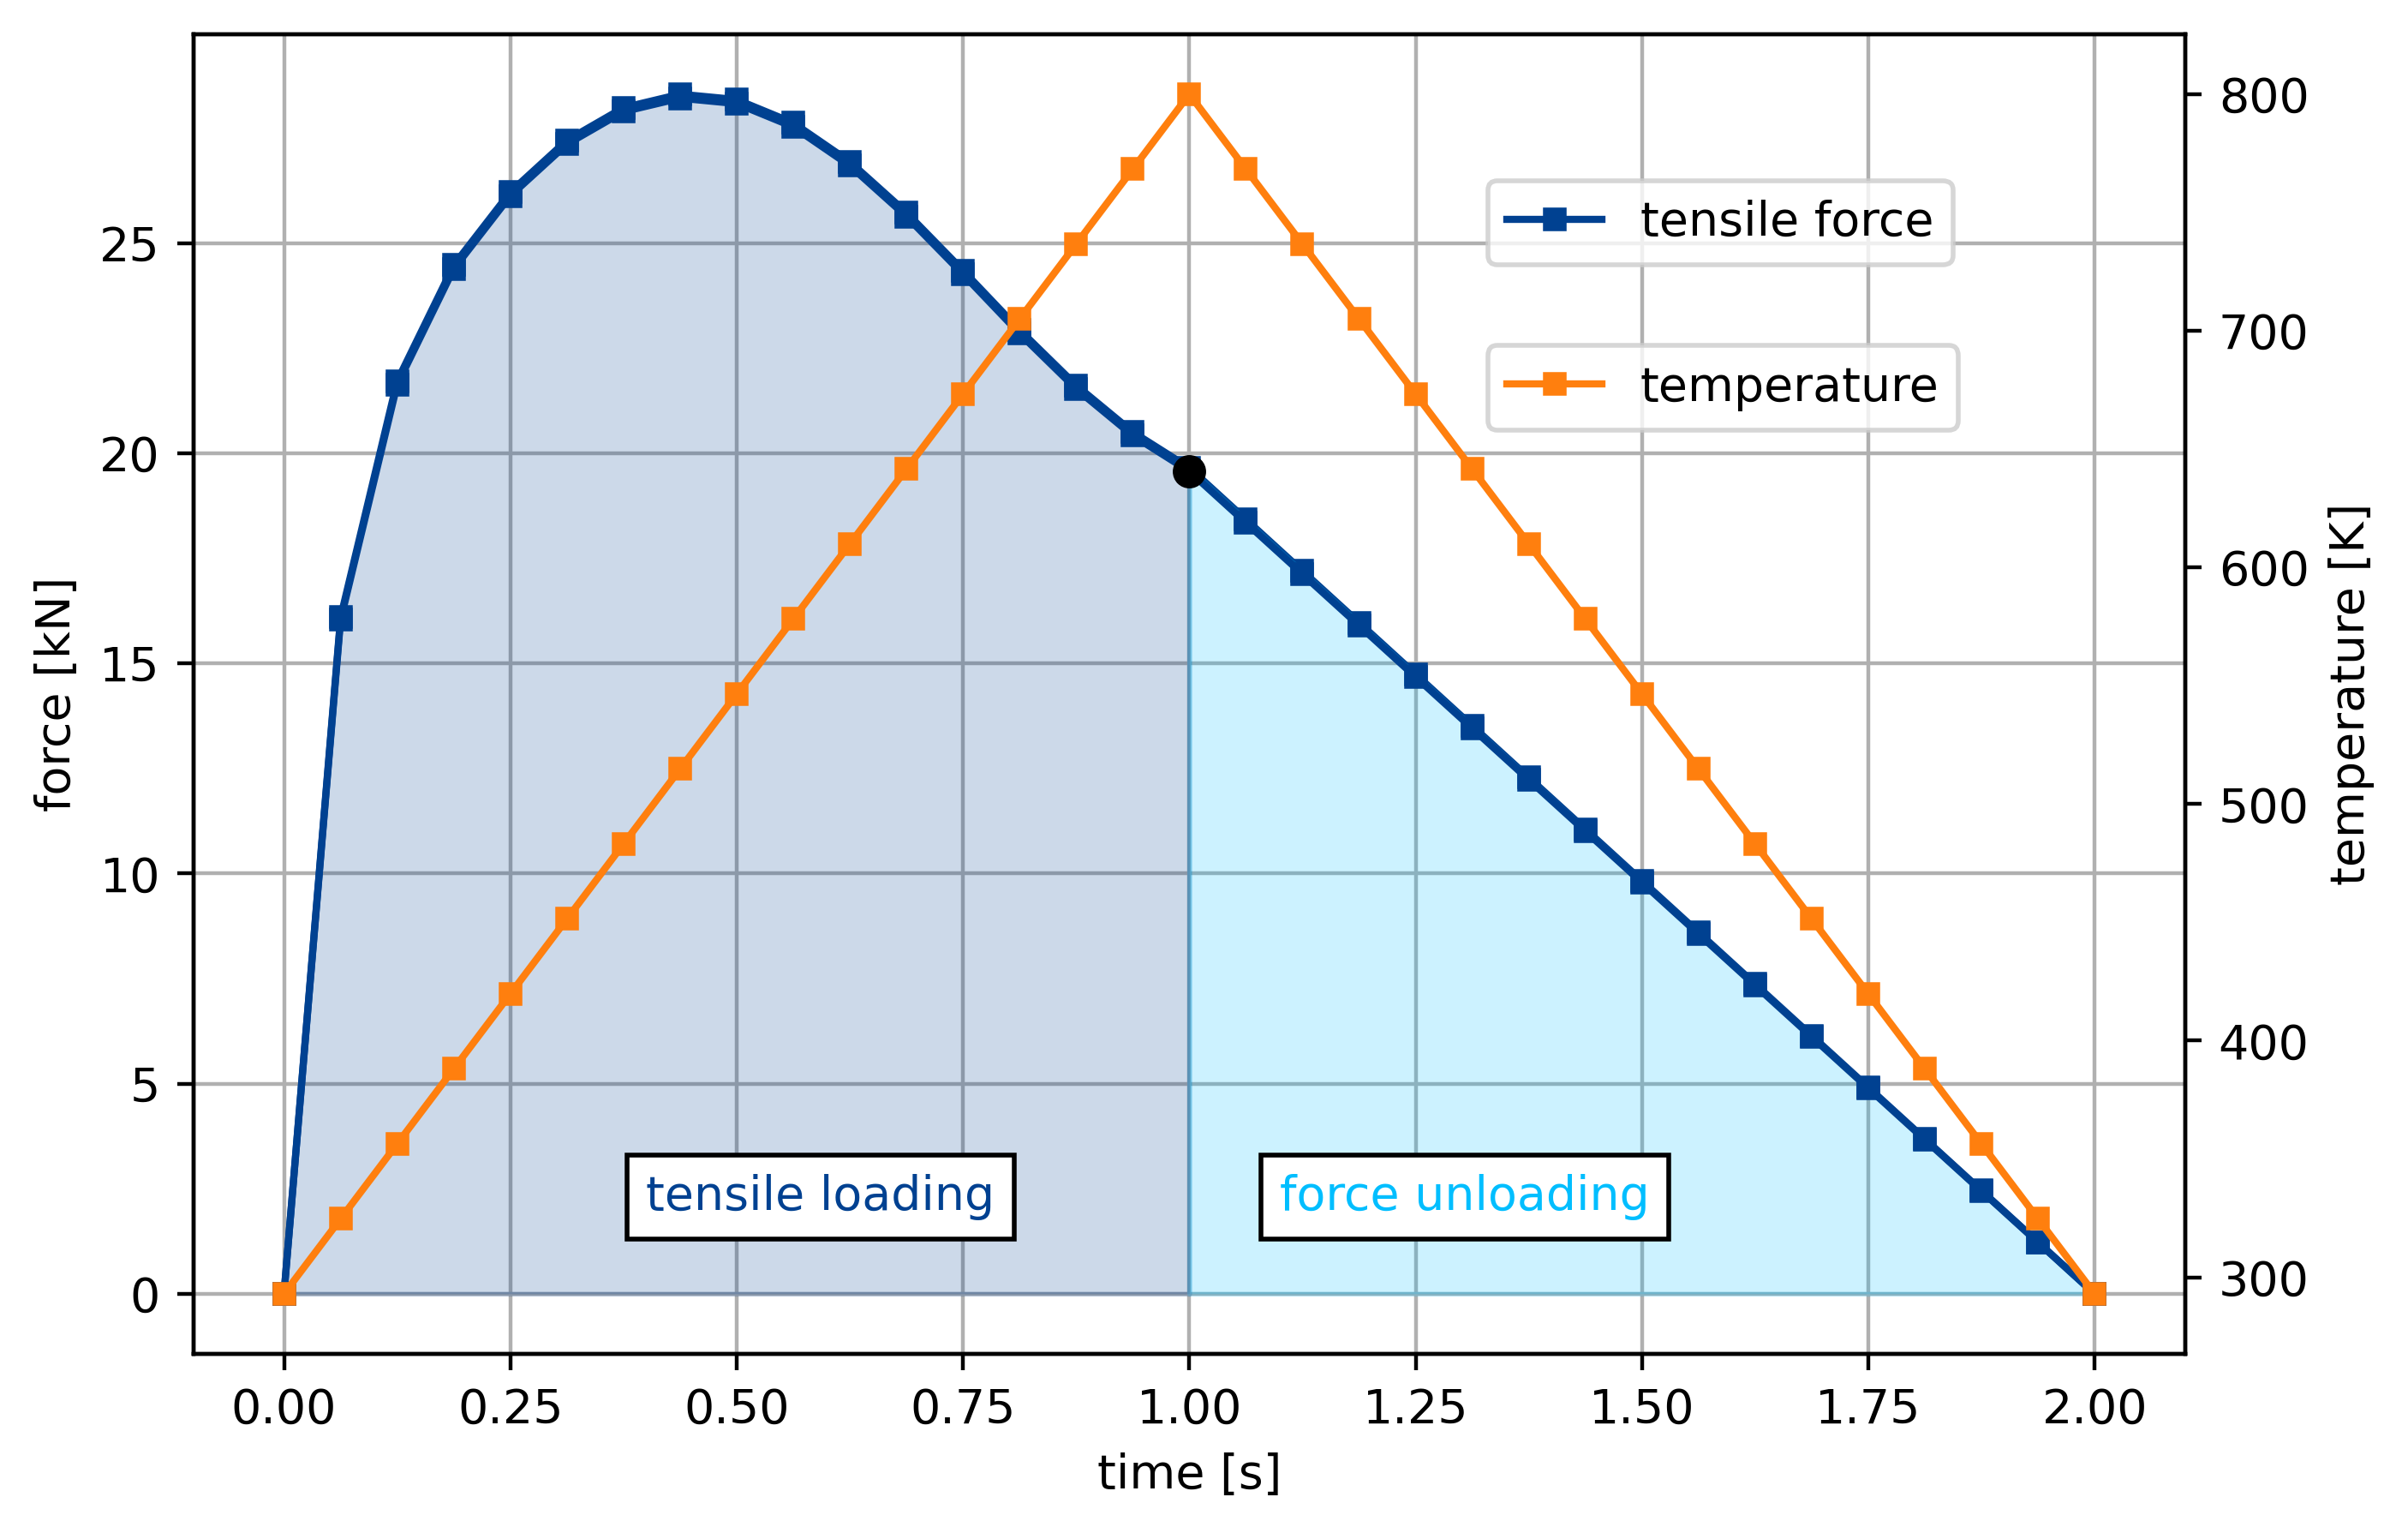

In [24]:
force = []
temp = []
for s in ("coarse", "fine"):  # 'medium',
    with h5py.File(
        os.path.join(data_path, f"vtk-notch/NTFA293K_{s}_temp_293-800.h5"), mode="r"
    ) as F:
        force.append(np.array(F["force32"]) / 1e6)
        temp.append(np.array(F["temperature32"]))

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
labels = False
for f, T in zip((force), (temp)):
    t = np.linspace(0, 2, f.size)
    ax.plot(t, f, "-s", ms=4, label="tensile force", color=colors[0])
    if labels:
        ax.plot(1.0, f[np.where(t == 1.0)], "o", color="black", ms=6)
    else:
        ax2 = ax.twinx()
        nhalf = int((t.size + 1) / 2)
        # ax.plot(1.0, f[np.where(t==1.0)], 'o', color='black', ms=6, label='start unloading', zorder=4)
        ax.fill_between(
            t[:nhalf], f[:nhalf], np.zeros(nhalf), color=colors[0], alpha=0.2, zorder=2
        )
        ax.fill_between(
            t[(nhalf - 1) :],
            f[(nhalf - 1) :],
            np.zeros(f.size - nhalf + 1),
            color=colors[1],
            alpha=0.2,
            zorder=2,
        )
        ax2.plot(t, T, "-s", ms=4, color=colors[2], zorder=4, label="temperature")
        ax.set_xlabel("time [s]")
        ax.set_ylabel("force [kN]")
        ax2.set_ylabel("temperature [K]")
        ax.text(
            0.4, 2, "tensile loading", color=colors[0], bbox=dict(facecolor="white")
        )
        ax.text(
            1.1, 2, "force unloading", color=colors[1], bbox=dict(facecolor="white")
        )
        ax.grid(zorder=1)
        ax.legend(loc=(0.65, 0.825))
        ax2.legend(loc=(0.65, 0.7))
    nhalf = int((t.size + 1) / 2)
    labels = True
fig.savefig(os.path.join(data_path, "figures", "twoscale_loading.pdf"))

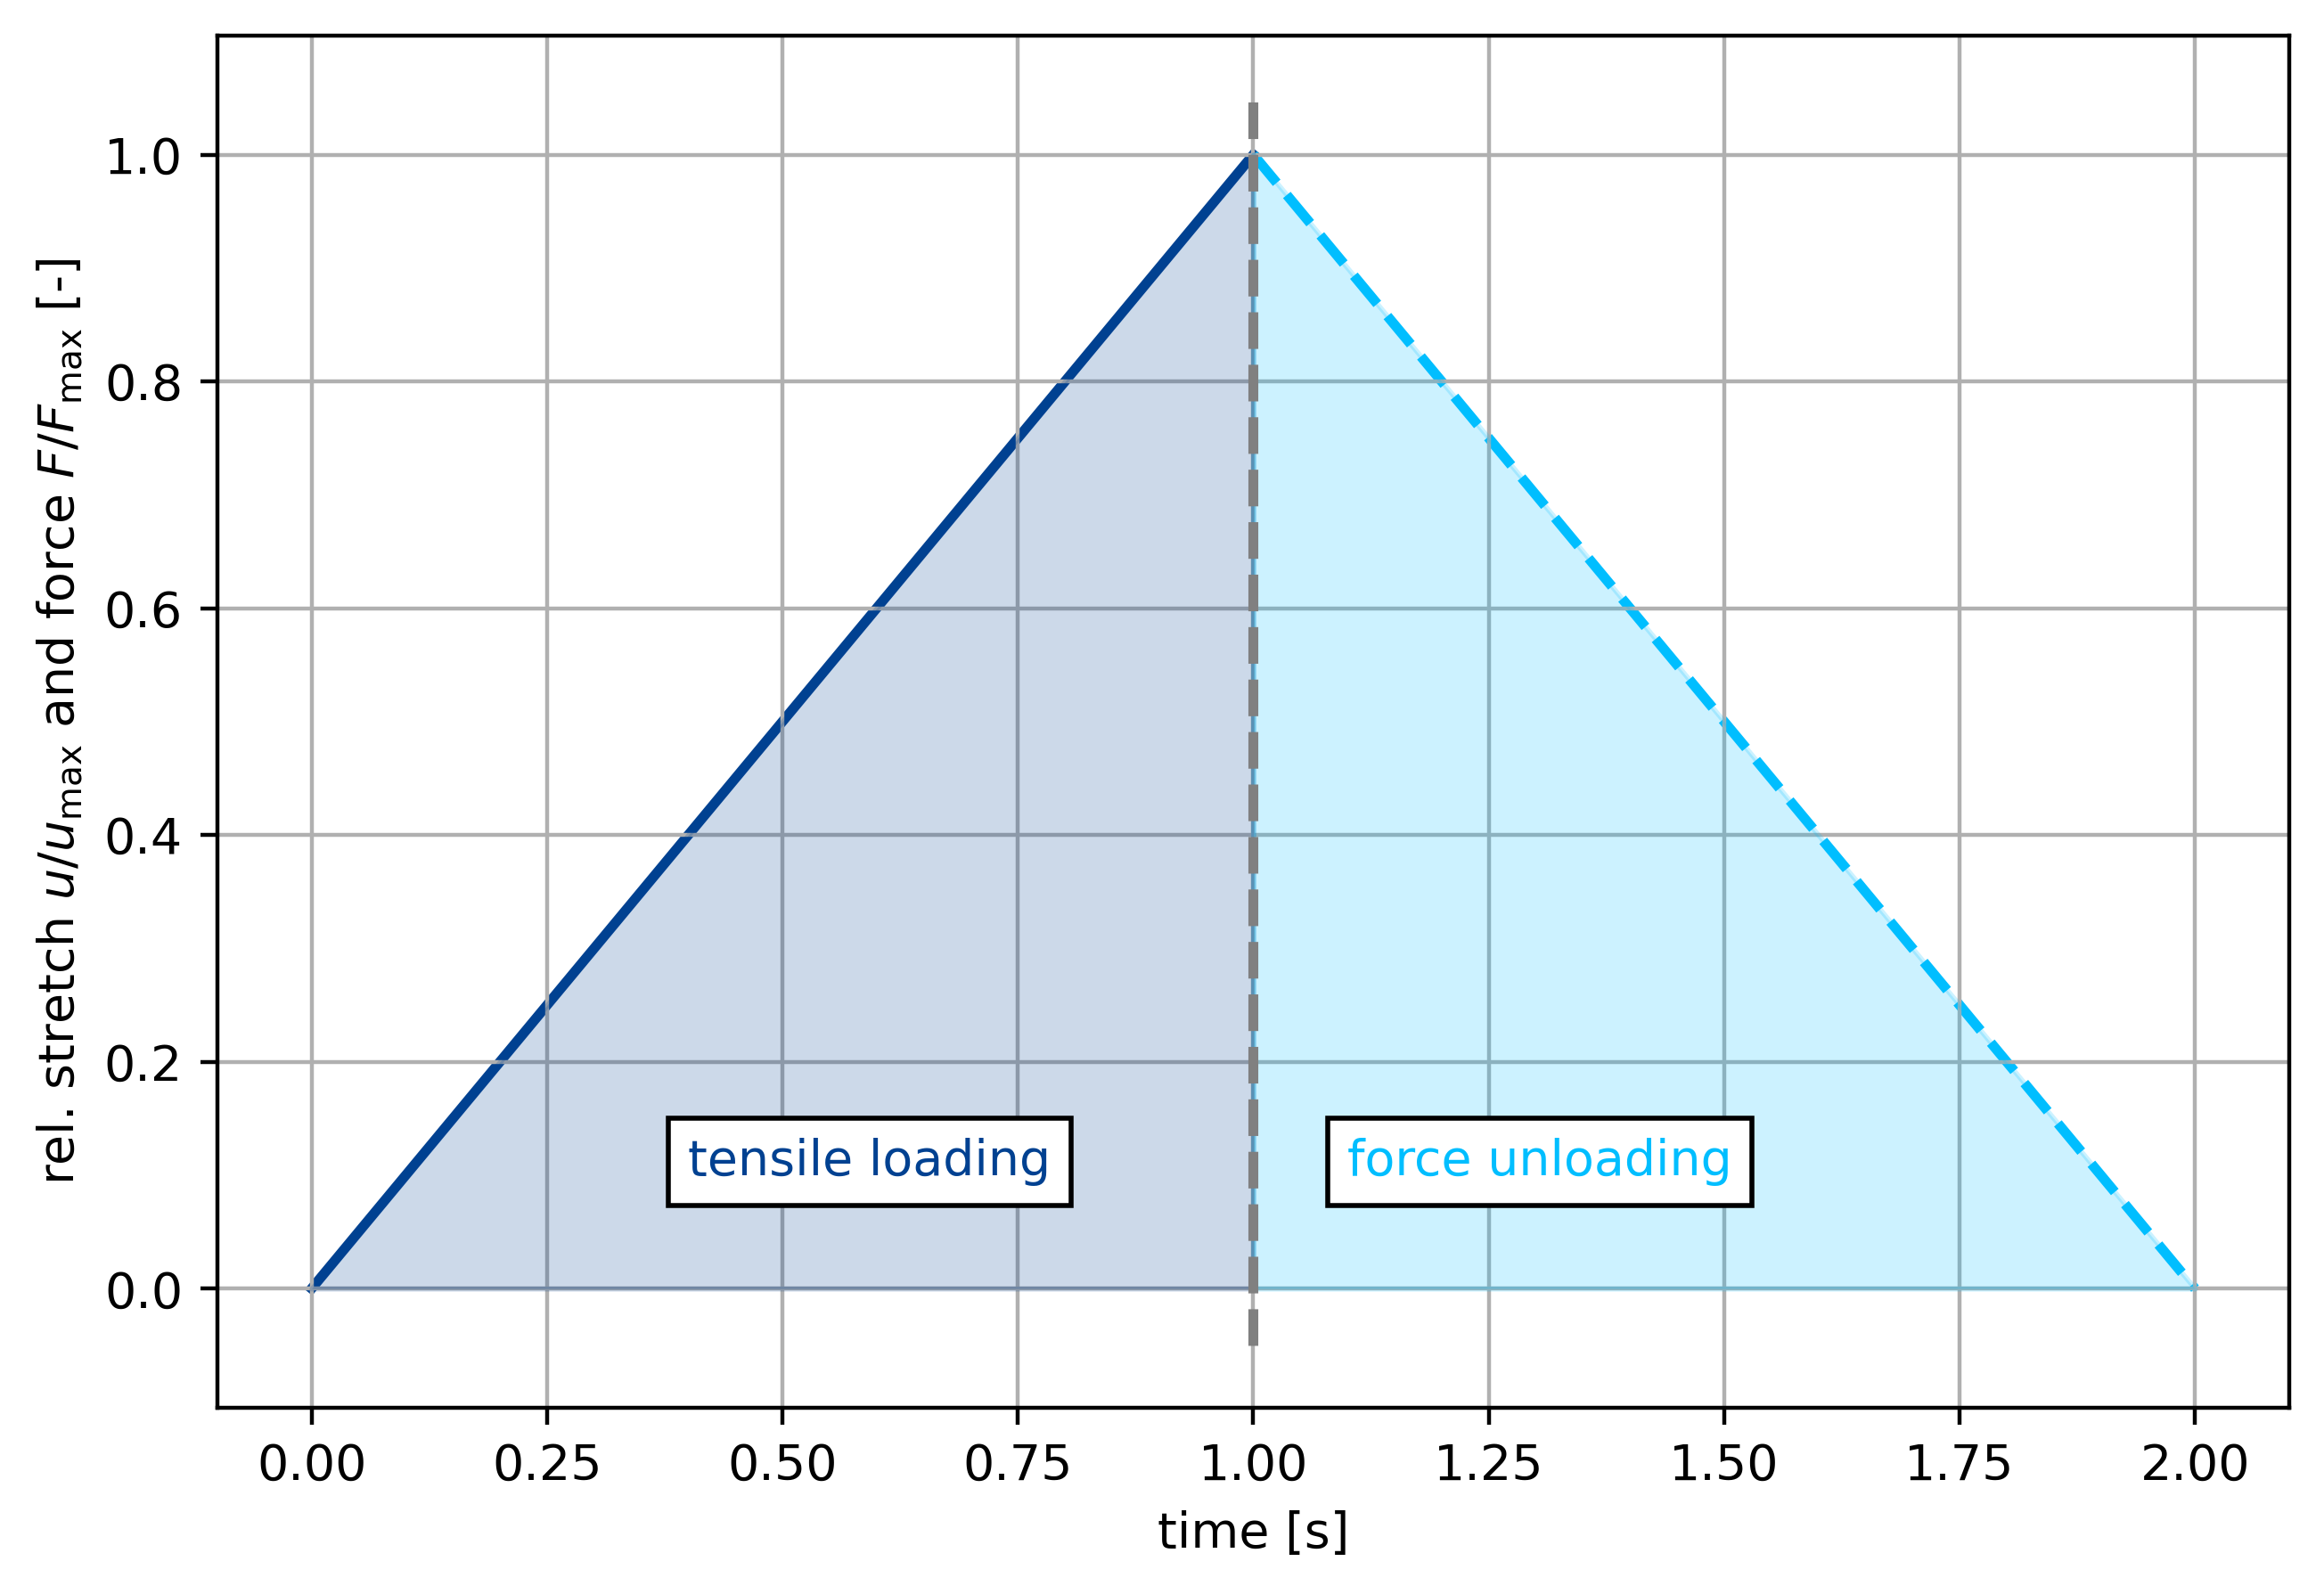

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.plot((1.0, 1.0), (-0.05, 1.05), "--", color="gray", lw=2, zorder=4)
ax.fill_between(
    (0.0, 1.0), (0.0, 1.0), (0.0, 0.0), color=colors[0], alpha=0.2, zorder=2
)
ax.fill_between(
    (1.0, 2.0), (1.0, 0.0), (0.0, 0.0), color=colors[1], alpha=0.2, zorder=2
)
ax.plot((0.0, 1.0), (0.0, 1.0), color=colors[0], lw=2, zorder=1)
ax.plot((1.0, 2.0), (1.0, 0.0), "--", color=colors[1], lw=2, zorder=1)
ax.text(0.4, 0.1, "tensile loading", color=colors[0], bbox=dict(facecolor="white"))
ax.text(1.1, 0.1, "force unloading", color=colors[1], bbox=dict(facecolor="white"))
ax.set_xlabel("time [s]")
ax.set_ylabel(r"rel. stretch $u/u_\mathrm{max}$ and force $F/F_\mathrm{max}$ [-]")
ax.grid(zorder=3)
fig.savefig(os.path.join(data_path, "figures", "twoscale_loading2.pdf"))